In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import spacy
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform, uniform
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [5]:
#Loading annotation and label file
data = pd.read_csv(r'.\AF50m_subset_REGEX_man_labels_5k.txt', sep="\t")
# Getting the annotatons that have been labeled manually
labeled = data.loc[data["manual_label"].notna(), ["protein_annotation", "manual_label"]]

In [ ]:
#just checking the classes
labeled["manual_label"].unique()

array(['proper', 'uninformative', 'low'], dtype=object)

In [ ]:
#any non ASCII characters?

non_ascii_re = re.compile(r"[^\x00-\x7F]")

# Boolean mask for rows containing non-ASCII chars
mask = labeled["protein_annotation"].str.contains(non_ascii_re)
non_ascii_rows = labeled[mask]
print(non_ascii_rows)

#so no non-ascii characters, cool. 

Empty DataFrame
Columns: [protein_annotation, manual_label]
Index: []


Different tests

In [ ]:

#preliminary cleaning, wil be improved 

# Makes everything lowercase and removes special characters except for underscores, colons, dots and hyphens

def clean_text_basic(text):
    
    text = text.lower()  # Lowercase
    text = re.sub(r"[^a-zA-Z0-9_:\.\-]+", " ", text)  # keep alphanumeric, underscores, colons, dots, hyphens
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces

    return text.strip()


In [15]:

# secondary cleanig, keeping more characters

# Makes everything lowercase and removes special characters except for underscores, colons, dots, hyphens, apostrophes and pluses
# the aim of this is to keep weird words that may be relevant in protein annotations intact

def clean_text2(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"[\[\]\(\)]", "", text)  # removing brackets etc
    text = re.sub(r"[^a-zA-Z0-9_:\.\-'+]+", " ", text)  # keep alphanumeric, underscores, colons, dots, hyphens, apostrophes, pluses
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces

    return text.strip()


In [6]:
# third cleaning function
# removes all special characters except for alphanumeric characters and spaces, and removes words with less than 2 characters

def clean_text3(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"[\[\]\(\)]", "", text)  # removing brackets etc
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # keep alphanumeric, underscores, colons, dots, hyphens, apostrophes, pluses
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces

    # Remove words shorter than 2 characters
    text = re.sub(r"\b\w{1}\b", "", text)  # Removes isolated 1-character tokens
    text = re.sub(r"\s+", " ", text)  # Clean up extra spaces again

    return text.strip()


In [ ]:
# Lets try lemmatization for cleaner 2

# lemmatization function using spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Custom tokenizer to keep certain special characters within tokens
ALLOWED_TOKEN_RE = re.compile(
    r"[A-Za-z0-9](?:[A-Za-z0-9_\-:\.+']*[A-Za-z0-9])?"
).match

# Override the default tokenizer
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=ALLOWED_TOKEN_RE)

def lemmatize_bio_text(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        t = token.text
        if re.search(r"[0-9_:\.\-]", t):  # if token has digits, underscores, colons, etc.
            lemmas.append(t)
        else:
            lemmas.append(token.lemma_)
    return " ".join(lemmas)

In [ ]:
# I want to compare original annotation, cleaned, and lemmatized versions
sub = labeled.sample(100, random_state=42).copy()
sub["cleaned"] = sub["protein_annotation"].apply(clean_text2)
sub["lemmatized"] = sub["cleaned"].apply(lemmatize_bio_text)
sub[["protein_annotation", "cleaned", "lemmatized"]]

,protein_annotation,cleaned,lemmatized
1501,GTP cyclohydrolase 1,gtp cyclohydrolase 1,gtp cyclohydrolase 1
2586,Capsular Polysaccharide Biosynthesis Protein,capsular polysaccharide biosynthesis protein,capsular polysaccharide biosynthesis protein
2653,Phage portal protein lambda family,phage portal protein lambda family,phage portal protein lambda family
1055,Leucine rich repeat 5,leucine rich repeat 5,leucine rich repeat 5
705,SNF2 family helicase,snf2 family helicase,snf2 family helicase
...,...,...,...
4740,ATP-grasp_3 domain-containing protein,atp-grasp_3 domain-containing protein,atp-grasp_3 domain-containing protein
2940,Prophage tail fiber assembly protein TfaE,prophage tail fiber assembly protein tfae,prophage tail fiber assembly protein tfae
3456,manganese and iron superoxide dismutase,manganese and iron superoxide dismutase,manganese and iron superoxide dismutase
373,Aspartyl:asparaginyl beta hydroxylase,aspartyl:asparaginyl beta hydroxylase,aspartyl:asparaginyl beta hydroxylase


In [7]:
# Let's adapdt lemmatization to cleaner 3
# tokens that contain both letters and digits e.g. DUF4376 should be kept as is

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Pattern for tokens that contain both letters and digits (e.g. DUF4376)
HAS_LETTER_AND_DIGIT = re.compile(r'(?=.*[a-zA-Z])(?=.*\d)')

def lemmatize_updated(text):
    doc = nlp(text)
    lemmas = []
    for tok in doc:
        if tok.is_space:
                continue
        t = tok.text
        if tok.is_alpha:
            lemmas.append(tok.lemma_.lower()) #eg binding -> bind
        elif HAS_LETTER_AND_DIGIT.search(t):
            # Keep alphanumeric tokens like DUF4376 as is
            lemmas.append(t.lower())
        # else: skip pure numbers and punctuation (shouldn’t occur post-cleaning)

    return " ".join(lemmas)

In [ ]:
# comparing original annotation, old and new lemmatizer, and the manual label
sub2 = labeled.sample(100, random_state=24).copy()
sub2["cleaned"] = sub2["protein_annotation"].apply(clean_text3)
sub2["lemmatized_old"] = sub2["cleaned"].apply(lemmatize_bio_text)
sub2["lemmatized_updated"] = sub2["cleaned"].apply(lemmatize_updated)
sub2[["protein_annotation", "lemmatized_old", "lemmatized_updated", "manual_label"]]

,protein_annotation,lemmatized_old,lemmatized_updated,manual_label
1941,"Contig93, whole genome shotgun sequence",contig93 whole genome shotgun sequence,contig93 whole genome shotgun sequence,uninformative
4088,SLAM family member 6-like isoform X2,slam family member like isoform x2,slam family member like isoform x2,proper
4564,FecR protein,fecr protein,fecr protein,proper
2075,"Mutator mutT protein (7,8-dihydro-8-oxoguanine...",mutator mutt protein dihydro oxoguanine tripho...,mutator mutt protein dihydro oxoguanine tripho...,proper
3,PadR domain-containing protein,padr domain contain protein,padr domain contain protein,proper
...,...,...,...,...
2366,Prophage pi2 protein 39,prophage pi2 protein 39,prophage pi2 protein,uninformative
1087,SOS-response repressor and protease LexA,sos response repressor and protease lexa,sos response repressor and protease lexa,proper
955,Tail fiber assembly protein from lambdoid prop...,tail fiber assembly protein from lambdoid prop...,tail fiber assembly protein from lambdoid prop...,proper
4685,Ring canal kelch protein,ring canal kelch protein,ring canal kelch protein,proper


Stopwords:

In [19]:
# built in english stopwords from sklearn
stopwords = list(ENGLISH_STOP_WORDS)

In [ ]:
# figuring out the most common words in the annotations to try and decide on stopwords

#vectorization method
vector = CountVectorizer(lowercase=True)

clean = labeled["protein_annotation"].apply(clean_text2)
vec = vector.fit_transform(clean)

#summarizing word frequencies
freqs = pd.DataFrame({
    "term": vector.get_feature_names_out(),
    "count": vec.toarray().sum(axis=0)
})

freqs = freqs.sort_values("count", ascending=False)
print(freqs.head(20))

                 term  count
2774          protein   2584
987            domain    726
2813         putative    602
1245           family    559
718        containing    539
1939             like    530
969               dna    331
2601            phage    311
3308          subunit    252
3565  uncharacterized    174
434           binding    173
3549             type    171
1793          isoform    165
3367             tail    150
888         dependent    134
2920        regulator    128
1843            kelch    125
1241           factor    123
1576         helicase    118
2768         prophage    108


Here I just looked at words appearing in all annotated sequences. Honestly, I should just remove protein. All sequences are supposed to be protein sequences. 


In [ ]:
#figuring out word counts per class
df = pd.DataFrame(vec.toarray(), columns=vector.get_feature_names_out())
df['label'] = labeled['manual_label'].values

class_word_counts = df.groupby('label').sum()

freqs_full = freqs.set_index("term").join(class_word_counts.T)
freqs_full = freqs_full.fillna(0).astype(int)

freqs_full = freqs_full.sort_values("count", ascending=False)

print(freqs_full.head(20))



                 count  low  proper  uninformative
term                                              
protein           2584  180    2149            255
domain             726   89     629              8
putative           602   13     562             27
family             559   40     508             11
containing         539   81     454              4
like               530    4     504             22
dna                331    0     326              5
phage              311    2     284             25
subunit            252    0     251              1
uncharacterized    174   33      21            120
binding            173    1     172              0
type               171    0     169              2
isoform            165    0     135             30
tail               150    0     150              0
dependent          134    0     134              0
regulator          128    0     127              1
kelch              125    0     125              0
factor             123    0    

In [ ]:
#trying to get a table with the frequencies of words in each class
df_bin = df.copy()
df_bin[vector.get_feature_names_out()] = (df_bin[vector.get_feature_names_out()] > 0).astype(int)

class_doc_freq = df_bin.groupby("label").sum()

class_sizes = df_bin["label"].value_counts().sort_index()

class_word_freq = class_doc_freq.div(class_sizes, axis=0)

freqs2 = pd.DataFrame({
    "term": vector.get_feature_names_out(),
    "total_count": vec.toarray().sum(axis=0)
}).set_index("term")

freqs_full2 = freqs2.join(class_word_freq.T)
freqs_full2 = freqs_full2.sort_values("total_count", ascending=False)

print(freqs_full2.head(20))

                 total_count       low    proper  uninformative
term                                                           
protein                 2584  0.927083  0.472203       0.558352
domain                   726  0.463542  0.140700       0.018307
putative                 602  0.067708  0.128346       0.061785
family                   559  0.208333  0.114619       0.025172
containing               539  0.421875  0.103409       0.009153
like                     530  0.020833  0.114848       0.045767
dna                      331  0.000000  0.072981       0.011442
phage                    311  0.010417  0.063830       0.057208
subunit                  252  0.000000  0.056280       0.002288
uncharacterized          174  0.171875  0.004804       0.274600
binding                  173  0.005208  0.039350       0.000000
type                     171  0.000000  0.038206       0.004577
isoform                  165  0.000000  0.030657       0.068650
tail                     150  0.000000  

What is my conclusion from this? At this moment I am not adding any stopwords. I should redo my analysis with my training data only. Hm. 
Redoing with clean-text3

In [14]:
# Redoing this analysis for clean_text3

#vectorization method
vector = CountVectorizer(lowercase=True)

clean = labeled["protein_annotation"].apply(clean_text3)
clean = clean.apply(lemmatize_updated)
vec = vector.fit_transform(clean)

terms = vector.get_feature_names_out()
count = np.asarray(vec.sum(axis=0)).ravel()

#summarizing word frequencies
freqs = pd.DataFrame({
    "term": terms,
    "frequency": count / 5000
})

freqs = freqs.sort_values("frequency", ascending=False)
freqs.head(20)

,term,frequency
2656,protein,0.5180
905,domain,0.1460
2694,putative,0.1208
1158,family,0.1122
645,contain,0.1094
1828,like,0.1070
888,dna,0.0668
2479,phage,0.0626
3160,subunit,0.0504
359,bind,0.0358


In [ ]:
#figuring out word counts per class
df = pd.DataFrame(vec.toarray(), columns=vector.get_feature_names_out())
df['label'] = labeled['manual_label'].values

class_word_counts = df.groupby('label').sum()

freqs_full = freqs.set_index("term").join(class_word_counts.T)
freqs_full = freqs_full.fillna(0).astype(int)

freqs_full = freqs_full.sort_values("count", ascending=False)

print(freqs_full.head(20))



                 count  low  proper  uninformative
term                                              
protein           2590  181    2153            256
domain             730   90     632              8
putative           604   13     564             27
family             561   40     510             11
contain            547   82     461              4
like               535    4     509             22
dna                334    0     329              5
phage              313    2     286             25
subunit            252    0     251              1
bind               179    1     178              0
uncharacterized    174   33      21            120
type               171    0     169              2
isoform            165    0     135             30
tail               151    0     151              0
dependent          134    0     134              0
regulator          129    0     128              1
kelch              125    0     125              0
factor             123    0    

In [ ]:
#trying to get a table with the frequencies of words in each class
df_bin = df.copy()
df_bin[vector.get_feature_names_out()] = (df_bin[vector.get_feature_names_out()] > 0).astype(int)

class_doc_freq = df_bin.groupby("label").sum()

class_sizes = df_bin["label"].value_counts().sort_index()

class_word_freq = class_doc_freq.div(class_sizes, axis=0)

freqs2 = pd.DataFrame({
    "term": vector.get_feature_names_out(),
    "total_count": vec.toarray().sum(axis=0)
}).set_index("term")

freqs_full2 = freqs2.join(class_word_freq.T)
freqs_full2 = freqs_full2.sort_values("total_count", ascending=False)

print(freqs_full2.head(20))

                 total_count       low    proper  uninformative
term                                                           
protein                 2590  0.932292  0.472889       0.560641
domain                   730  0.468750  0.141386       0.018307
putative                 604  0.067708  0.128803       0.061785
family                   561  0.208333  0.115077       0.025172
contain                  547  0.427083  0.105010       0.009153
like                     535  0.020833  0.115992       0.045767
dna                      334  0.000000  0.073667       0.011442
phage                    313  0.010417  0.064287       0.057208
subunit                  252  0.000000  0.056280       0.002288
bind                     179  0.005208  0.040723       0.000000
uncharacterized          174  0.171875  0.004804       0.274600
type                     171  0.000000  0.038206       0.004577
isoform                  165  0.000000  0.030657       0.068650
tail                     151  0.000000  

My conclusion is kinda that I'm ignoring this, might want to consider exploring this more thoroughly

Vectoriser

In [ ]:
#preliminary TF-IDF vectorizer
vectorizer_basic = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,2), # might want to increase
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# Removing min_df to see how it affects things
vectorizer2 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, 
    ngram_range=(1,2), # might want to increase
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# Testing without min_df and more n-grams
vectorizer2_5 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, 
    ngram_range=(1,4), # might want to increase
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# min_df is back, and more n-grams
vectorizer3 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,3), # might want to increase
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [20]:
# trying to adapt the token pattern to include more characters, so weird words are kept as tokens
vectorizer4 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,2), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# does increasing n-grams to the costume tokeniser help?
# no :(
vectorizer5 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,3), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# Removing ngrams from the costume tokeniser
vectorizer6 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,1), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# Does costume stopwords help for the costume tokeniser? 
stop = ["protein", "domain", "family", "like", "containing"]
vectorizer7 = TfidfVectorizer(
    lowercase=False,
    stop_words=stop, 
    ngram_range=(1,1), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# Trying without min_df for the costume tokeniser

vectorizer8 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,2), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [ ]:
# trying to increase n-grams again without min_df for the costume tokeniser

vectorizer9 = TfidfVectorizer(
    lowercase=False,
    # stop_words=stopwords, # only english atm
    ngram_range=(1,4), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    max_df=0.9 # words that appear in more than 80% of annotations are ignored
)

General pipeline

In [ ]:

# general classification testing function
# uses a logistic regression classifier to test the performance of different vectorizers and cleaning methods
def classification_test(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = LogisticRegression(solver="lbfgs", max_iter=1000)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

Can we improve the logistic regression?

In [ ]:
#setup for tuning tests
x = labeled["protein_annotation"].apply(clean_text3)
x = x.apply(lemmatize_bio_text)
y = labeled["manual_label"]

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# building vectorizer on train set and transforming both train and test
train_vectors = vectorizer2.fit_transform(x_train)
test_vectors = vectorizer2.transform(x_test)

In [ ]:
pipe = Pipeline([
    ("vectorizer", vectorizer2),
    ("classifier", LogisticRegression(max_iter=5000, multi_class="multinomial"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_distributions = [
    {
        # classifier params (lbfgs, L2)
        "classifier__solver": ["lbfgs"],
        "classifier__penalty": ["l2"],
        "classifier__C": loguniform(1e-2, 1e2),
        "classifier__class_weight": [None, "balanced"],
    },
    {
        # SAGA block (allows L1/elastic-net)
        "classifier__solver": ["saga"],
        "classifier__penalty": ["l1", "l2", "elasticnet"],
        "classifier__l1_ratio": uniform(0.0, 1.0),
        "classifier__C": loguniform(1e-2, 1e2),
        "classifier__class_weight": [None, "balanced"],
    }
]

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(x_train, y_train)
print(search.best_params_)
print(search.best_score_)
print(classification_report(y_test, search.predict(x_test)))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


{'classifier__C': np.float64(13.145103232150124), 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
0.6988426141617802
               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



Optimised logistic regression

In [ ]:

def logistic_opt(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = LogisticRegression(solver="lbfgs", max_iter=1000, penalty='l2', C=13.1451, class_weight=None)

    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



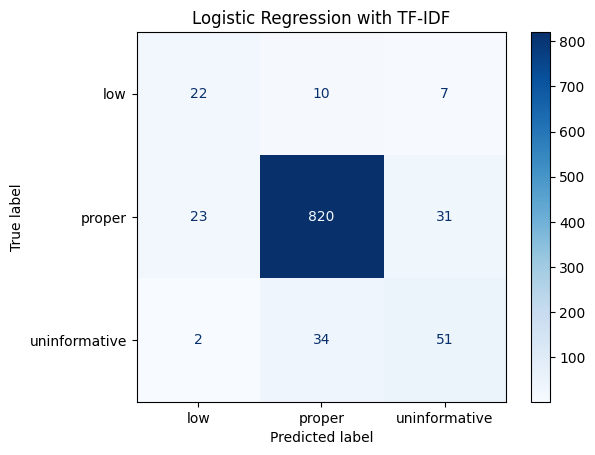

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2, "Logistic Regression with TF-IDF")

               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



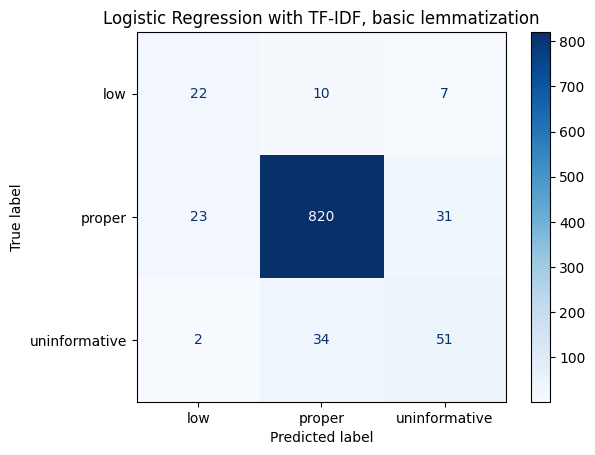

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2, "Logistic Regression with TF-IDF, basic lemmatization", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.48      0.59      0.53        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.71      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



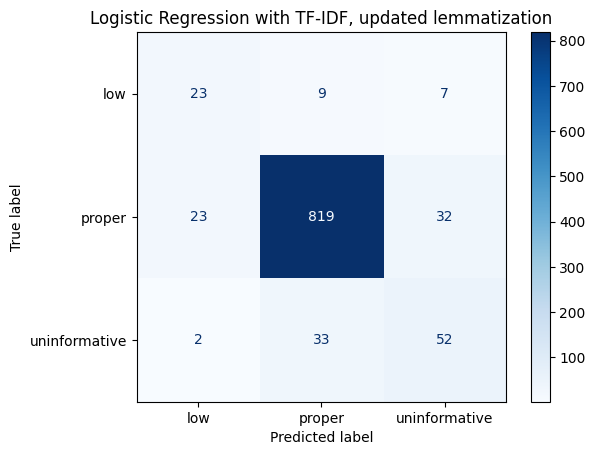

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2, "Logistic Regression with TF-IDF, updated lemmatization", lemmatizer=lemmatize_updated)

SVM regression

In [ ]:
# trying different classifier

def classificationSVM(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = LinearSVC(class_weight='balanced', random_state=42)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

lets see if we can improve the SVM

In [ ]:
# trying again with pipeline and grid search
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("vectorizer", vectorizer2),
    ("svm", LinearSVC())  # OvR multiclass by default
])

param_grid = {
    # LinearSVC hyperparams
    "svm__C": np.logspace(-4, 3, 10),
    "svm__loss": ["squared_hinge"],   # best supported
    "svm__penalty": ["l2"],
    # If you have MANY features >> samples, keep dual=True (default).
    # If samples >> features, try dual=False as well:
    # "svm__dual": [True, False],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1
)

grid.fit(x_train, y_train)
print("Best params:", grid.best_params_)
print("CV f1_macro:", grid.best_score_)
print("\nTest performance:\n", classification_report(y_test, grid.predict(x_test)))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'svm__C': np.float64(0.774263682681127), 'svm__class_weight': 'balanced', 'svm__loss': 'squared_hinge', 'svm__penalty': 'l2'}
CV f1_macro: 0.7106923137625335

Test performance:
                precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



In [17]:
# optimising SVM classifier

def SVMopt(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = LinearSVC(C = 0.7743, class_weight='balanced', loss = 'squared_hinge', penalty='l2', random_state=42)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



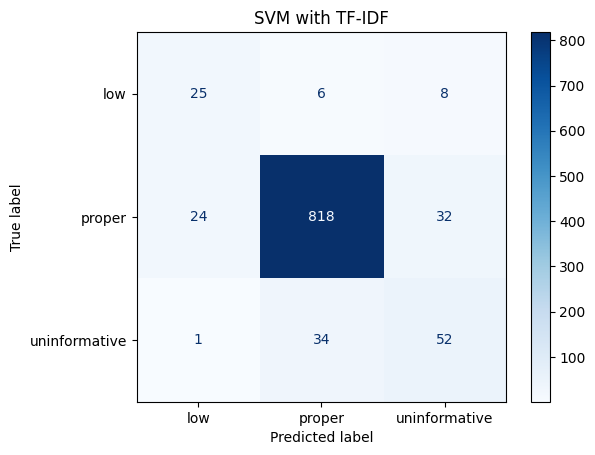

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2, "SVM with TF-IDF")


               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



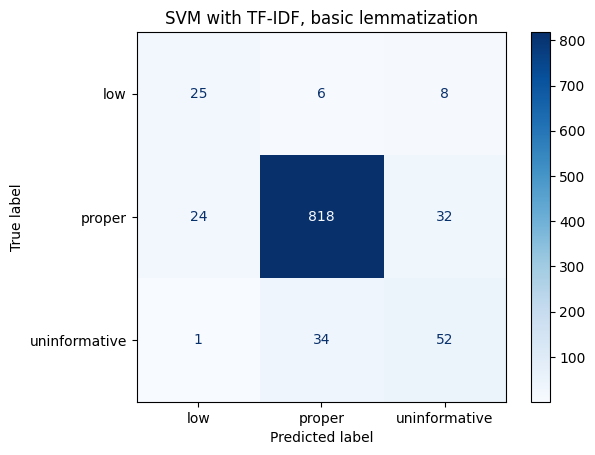

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2, "SVM with TF-IDF, basic lemmatization", lemmatizer=lemmatize_bio_text)


               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.61      0.59        87

     accuracy                           0.90      1000
    macro avg       0.67      0.73      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



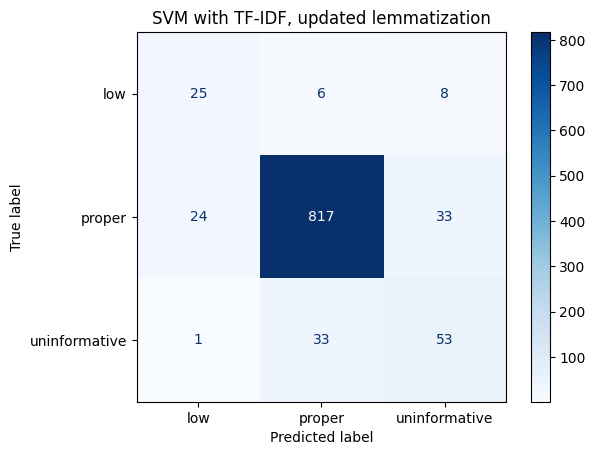

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2, "SVM with TF-IDF, updated lemmatization", lemmatizer=lemmatize_updated)

Trying random forest

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x = labeled["protein_annotation"].apply(clean_text3)
x = x.apply(lemmatize_bio_text)
y = labeled["manual_label"]

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

param_distributions = {
    "rf__n_estimators": randint(300, 1200),
    "rf__max_depth": [10, 20, 30, 40, 50, None],
    "rf__min_samples_split": randint(2, 20),
    "rf__min_samples_leaf": randint(1, 10),
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "rf__bootstrap": [True, False],
    "rf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(x_train, y_train)
print("Best params:", search.best_params_)
print("CV f1_macro:", search.best_score_)



Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 11, 'rf__n_estimators': 910, 'tfidf__max_df': np.float64(0.7685650065391898), 'tfidf__min_df': 3}
CV f1_macro: 0.6137378431611626


In [ ]:
# Random forest

def RF(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = RandomForestClassifier(
        bootstrap=True,
        class_weight='balanced',
        max_depth=10,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=11,
        n_estimators=910,
        random_state=42,
        n_jobs=-1   
    )
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

In [ ]:
#okay. trying with SVD again. Let's see how it goes.

import numpy as np
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# X: iterable of texts, y: labels
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cast to float32 to halve memory after SVD
to_float32 = FunctionTransformer(lambda X: X.astype(np.float32), accept_sparse=True)

pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("svd", TruncatedSVD(random_state=42)),     # we'll tune n_components
    ("astype32", to_float32),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# ---- Broad, fast search (recommended first) ----
param_distributions = {

    # SVD dimensionality (jointly tuned)
    "svd__n_components": randint(300, 1600),

    # Forest
    "rf__n_estimators": randint(400, 1200),
    "rf__max_depth": [15, 25, 40, None],
    "rf__min_samples_split": randint(2, 20),
    "rf__min_samples_leaf": randint(1, 10),
    "rf__max_features": ["sqrt", "log2", 0.4, 0.6],
    "rf__bootstrap": [True, False],
    "rf__class_weight": [None, "balanced"],  # use if classes are imbalanced
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=60,              # increase if you can
    scoring="f1_macro",     # good for multi-class + imbalance
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(x_train, y_train)
print("Best params:", search.best_params_)
print("CV f1_macro:", search.best_score_)

y_pred = search.predict(x_test)
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
best_model = search.best_estimator_


Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

Naive Bayes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

#setup for tuning tests
x = labeled["protein_annotation"].apply(clean_text3)
x = x.apply(lemmatize_bio_text)
y = labeled["manual_label"]

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("nb", MultinomialNB())
])

param_grid = {
    "nb__alpha": np.logspace(-3, 1, 10),
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)
print("\nTest performance:\n", classification_report(y_test, grid.predict(x_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'nb__alpha': np.float64(0.001)}
Best CV f1_macro: 0.6986835088997003

Test performance:
                precision    recall  f1-score   support

          low       0.44      0.51      0.48        39
       proper       0.94      0.96      0.95       874
uninformative       0.71      0.52      0.60        87

     accuracy                           0.90      1000
    macro avg       0.70      0.66      0.67      1000
 weighted avg       0.90      0.90      0.90      1000



In [ ]:
# Multimodal Naive Bayes

def MNB(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = MultinomialNB(alpha=0.001)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

In [ ]:
from sklearn.naive_bayes import ComplementNB

pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("cnb", ComplementNB())
])
param_grid = {
    "cnb__alpha": np.logspace(-3, 1, 10),
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)
print("\nTest performance:\n", classification_report(y_test, grid.predict(x_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'cnb__alpha': np.float64(0.007742636826811269)}
Best CV f1_macro: 0.6688436312224886

Test performance:
                precision    recall  f1-score   support

          low       0.29      0.79      0.42        39
       proper       0.98      0.89      0.93       874
uninformative       0.54      0.61      0.57        87

     accuracy                           0.86      1000
    macro avg       0.60      0.77      0.64      1000
 weighted avg       0.92      0.86      0.88      1000



In [ ]:
# Complement Naive Bayes

def CNB(data, cleaner, vectorizer, title, lemmatizer = None):

    x = data["protein_annotation"].apply(cleaner)
    if lemmatizer:
        x = x.apply(lemmatizer)
    y = data["manual_label"]

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(x_train)
    test_vectors = vectorizer.transform(x_test)

    #training classifier
    clf = ComplementNB(alpha=0.007743)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

Classifier accuracy tests

               precision    recall  f1-score   support

          low       1.00      0.03      0.05        39
       proper       0.91      1.00      0.95       874
uninformative       0.82      0.41      0.55        87

     accuracy                           0.91      1000
    macro avg       0.91      0.48      0.52      1000
 weighted avg       0.91      0.91      0.88      1000



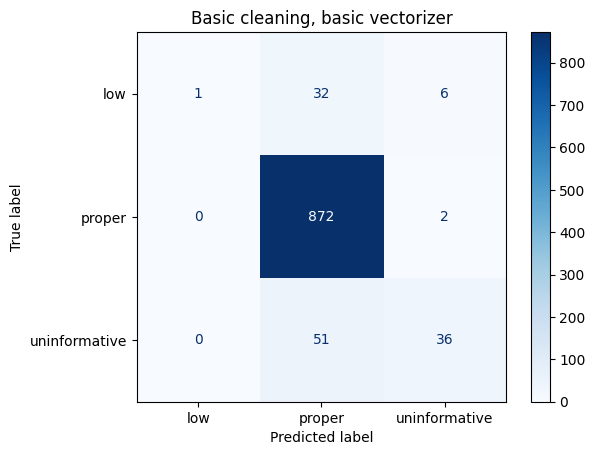

In [ ]:
classification_test(labeled, clean_text_basic, vectorizer_basic, "Basic cleaning, basic vectorizer")

               precision    recall  f1-score   support

          low       1.00      0.03      0.05        39
       proper       0.91      1.00      0.95       874
uninformative       0.82      0.41      0.55        87

     accuracy                           0.91      1000
    macro avg       0.91      0.48      0.52      1000
 weighted avg       0.91      0.91      0.88      1000



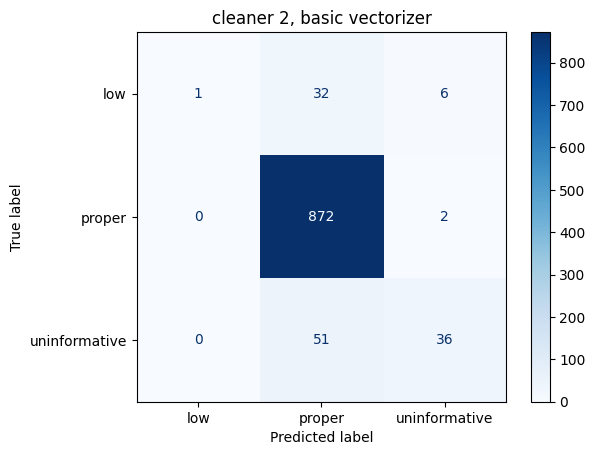

In [ ]:
classification_test(labeled, clean_text2, vectorizer_basic, "cleaner 2, basic vectorizer")

               precision    recall  f1-score   support

          low       0.37      0.54      0.44        39
       proper       0.93      0.93      0.93       874
uninformative       0.59      0.46      0.52        87

     accuracy                           0.88      1000
    macro avg       0.63      0.64      0.63      1000
 weighted avg       0.88      0.88      0.88      1000



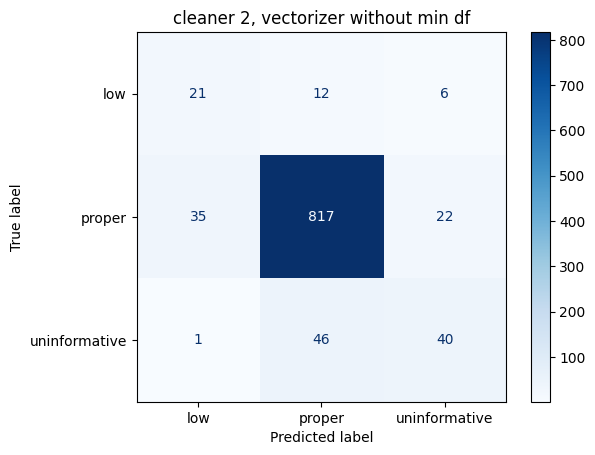

In [ ]:
classification_test(labeled, clean_text2, vectorizer2, "cleaner 2, vectorizer without min df")

               precision    recall  f1-score   support

          low       0.37      0.54      0.44        39
       proper       0.93      0.94      0.93       874
uninformative       0.60      0.46      0.52        87

     accuracy                           0.88      1000
    macro avg       0.63      0.64      0.63      1000
 weighted avg       0.88      0.88      0.88      1000



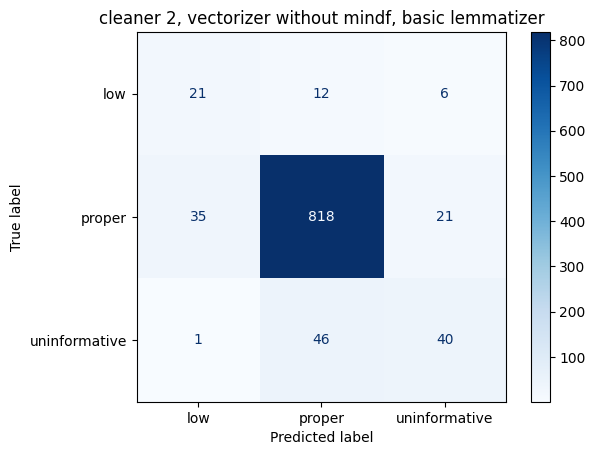

In [ ]:
classification_test(labeled, clean_text2, vectorizer2, "cleaner 2, vectorizer without mindf, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.70      0.18      0.29        39
       proper       0.92      0.97      0.95       874
uninformative       0.60      0.47      0.53        87

     accuracy                           0.90      1000
    macro avg       0.74      0.54      0.59      1000
 weighted avg       0.89      0.90      0.88      1000



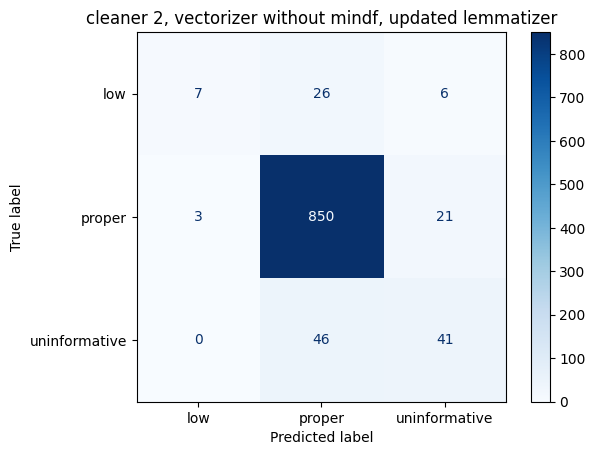

In [ ]:
classification_test(labeled, clean_text2, vectorizer2, "cleaner 2, vectorizer without mindf, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.47      0.54      0.50        39
       proper       0.93      0.95      0.94       874
uninformative       0.59      0.46      0.52        87

     accuracy                           0.89      1000
    macro avg       0.66      0.65      0.65      1000
 weighted avg       0.89      0.89      0.89      1000



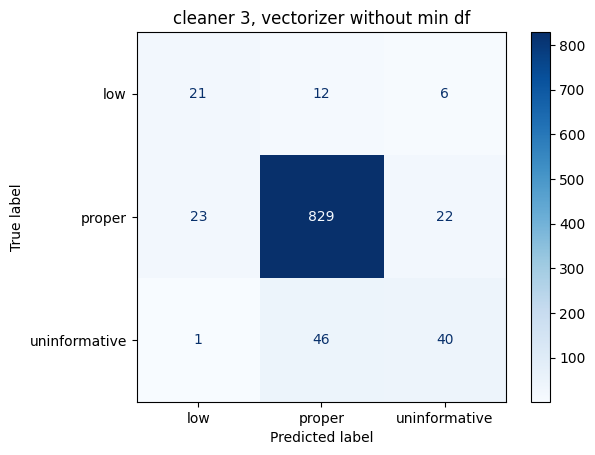

In [ ]:
classification_test(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer without min df")

               precision    recall  f1-score   support

          low       0.48      0.54      0.51        39
       proper       0.93      0.95      0.94       874
uninformative       0.60      0.46      0.52        87

     accuracy                           0.89      1000
    macro avg       0.67      0.65      0.66      1000
 weighted avg       0.89      0.89      0.89      1000



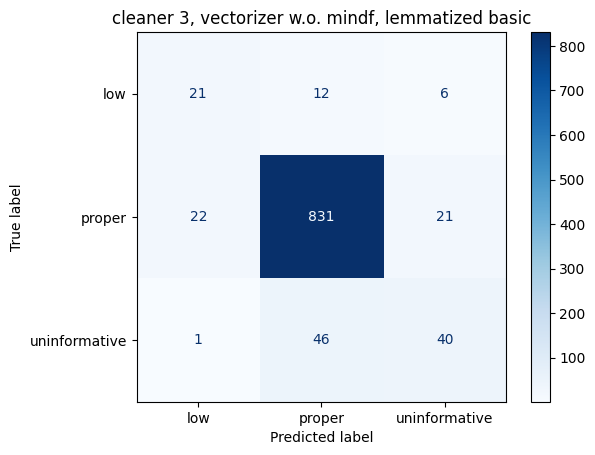

In [ ]:
classification_test(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. mindf, lemmatized basic", lemmatizer=lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.48      0.54      0.51        39
       proper       0.94      0.95      0.94       874
uninformative       0.59      0.47      0.53        87

     accuracy                           0.89      1000
    macro avg       0.67      0.65      0.66      1000
 weighted avg       0.89      0.89      0.89      1000



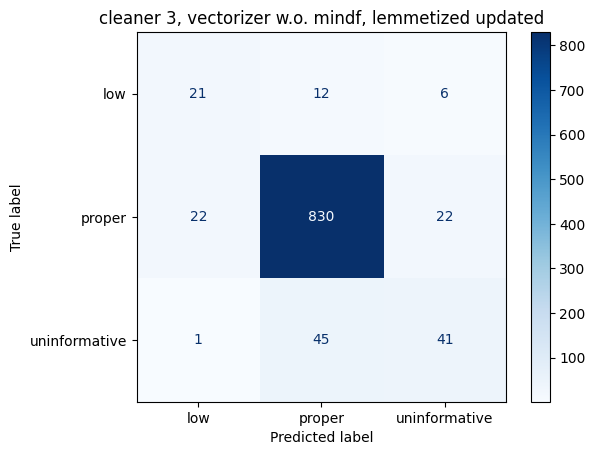

In [ ]:
classification_test(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. mindf, lemmetized updated", lemmatizer=lemmatize_updated)

               precision    recall  f1-score   support

          low       0.36      0.54      0.43        39
       proper       0.93      0.93      0.93       874
uninformative       0.59      0.46      0.52        87

     accuracy                           0.88      1000
    macro avg       0.63      0.64      0.63      1000
 weighted avg       0.88      0.88      0.88      1000



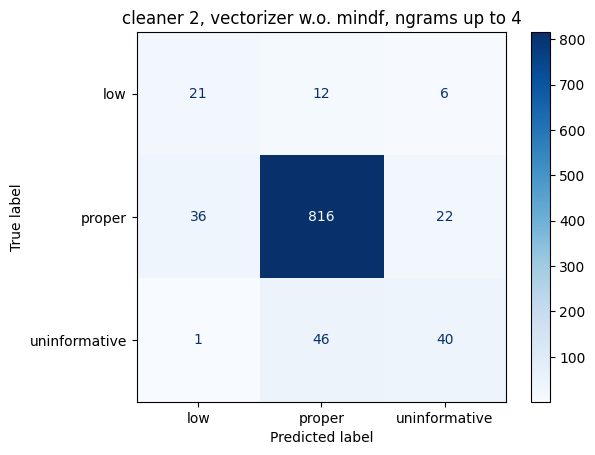

In [ ]:
classification_test(labeled, clean_text2, vectorizer2_5, "cleaner 2, vectorizer w.o. mindf, ngrams up to 4")

               precision    recall  f1-score   support

          low       0.43      0.54      0.48        39
       proper       0.93      0.94      0.94       874
uninformative       0.59      0.46      0.52        87

     accuracy                           0.89      1000
    macro avg       0.65      0.65      0.64      1000
 weighted avg       0.88      0.89      0.88      1000



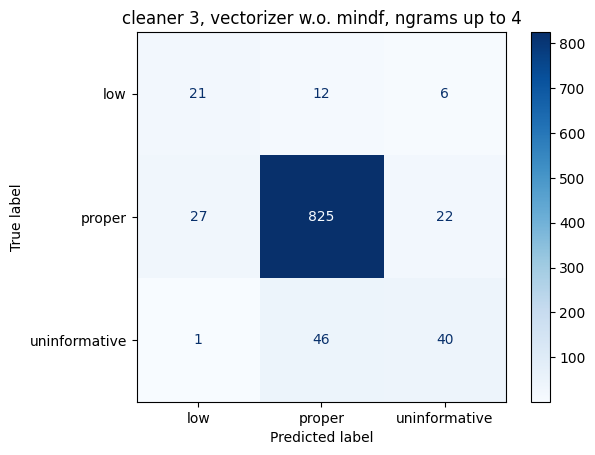

In [ ]:
classification_test(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. mindf, ngrams up to 4")

               precision    recall  f1-score   support

          low       0.45      0.54      0.49        39
       proper       0.93      0.95      0.94       874
uninformative       0.60      0.46      0.52        87

     accuracy                           0.89      1000
    macro avg       0.66      0.65      0.65      1000
 weighted avg       0.89      0.89      0.89      1000



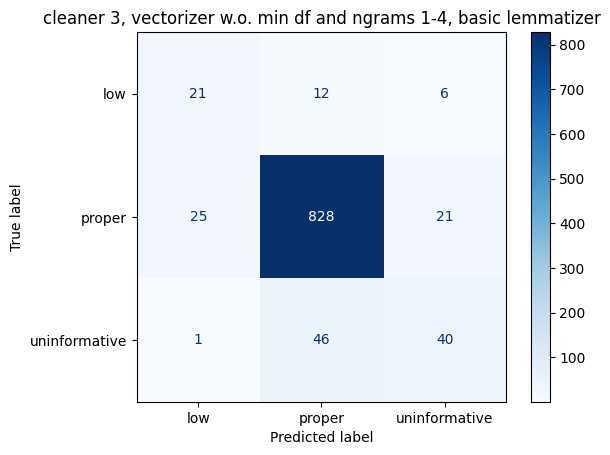

In [ ]:
classification_test(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams 1-4, basic lemmatizer", lemmatizer=lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.45      0.54      0.49        39
       proper       0.94      0.95      0.94       874
uninformative       0.59      0.47      0.53        87

     accuracy                           0.89      1000
    macro avg       0.66      0.65      0.65      1000
 weighted avg       0.89      0.89      0.89      1000



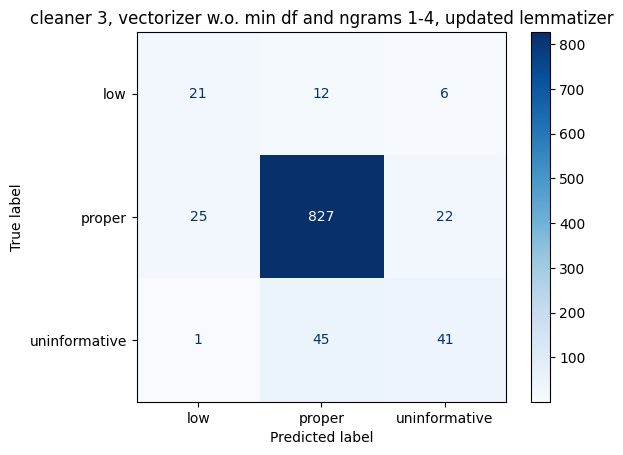

In [ ]:
classification_test(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams 1-4, updated lemmatizer", lemmatizer=lemmatize_updated)

               precision    recall  f1-score   support

          low       0.00      0.00      0.00        39
       proper       0.91      1.00      0.95       874
uninformative       0.80      0.41      0.55        87

     accuracy                           0.91      1000
    macro avg       0.57      0.47      0.50      1000
 weighted avg       0.87      0.91      0.88      1000



c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

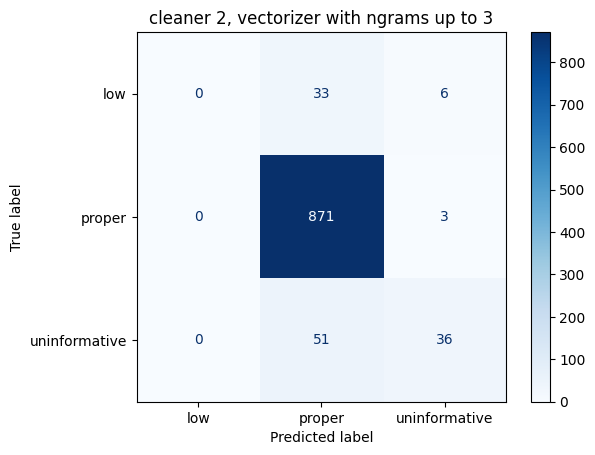

In [ ]:
classification_test(labeled, clean_text2, vectorizer3, "cleaner 2, vectorizer with ngrams up to 3")

               precision    recall  f1-score   support

          low       1.00      0.03      0.05        39
       proper       0.91      1.00      0.95       874
uninformative       0.80      0.41      0.55        87

     accuracy                           0.91      1000
    macro avg       0.90      0.48      0.52      1000
 weighted avg       0.91      0.91      0.88      1000



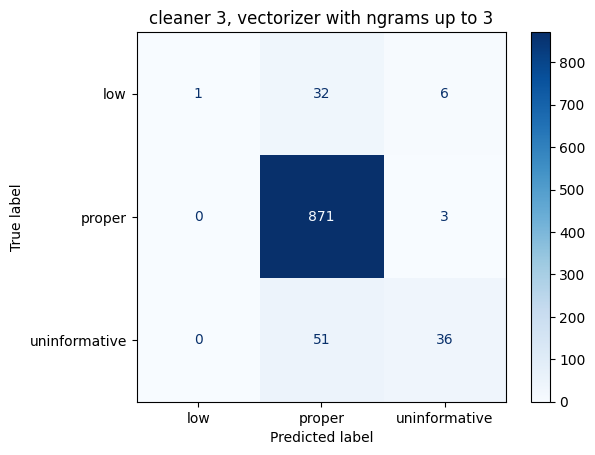

In [ ]:
classification_test(labeled, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3")

               precision    recall  f1-score   support

          low       1.00      0.03      0.05        39
       proper       0.91      1.00      0.95       874
uninformative       0.78      0.41      0.54        87

     accuracy                           0.91      1000
    macro avg       0.90      0.48      0.51      1000
 weighted avg       0.90      0.91      0.88      1000



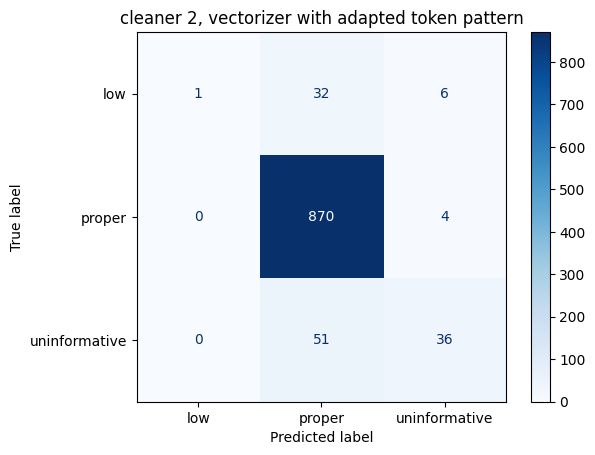

In [ ]:
classification_test(labeled, clean_text2, vectorizer4, "cleaner 2, vectorizer with adapted token pattern")

               precision    recall  f1-score   support

          low       0.00      0.00      0.00        39
       proper       0.91      1.00      0.95       874
uninformative       0.79      0.43      0.55        87

     accuracy                           0.91      1000
    macro avg       0.57      0.47      0.50      1000
 weighted avg       0.87      0.91      0.88      1000



c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

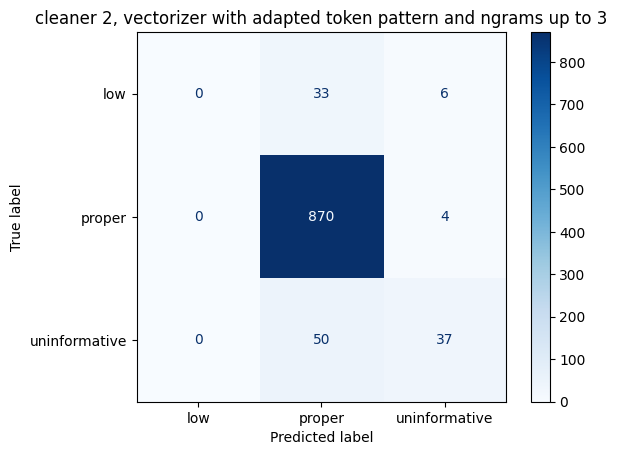

In [ ]:
classification_test(labeled, clean_text2, vectorizer5, "cleaner 2, vectorizer with adapted token pattern and ngrams up to 3")

               precision    recall  f1-score   support

          low       1.00      0.10      0.19        39
       proper       0.91      0.99      0.95       874
uninformative       0.80      0.41      0.55        87

     accuracy                           0.91      1000
    macro avg       0.90      0.50      0.56      1000
 weighted avg       0.91      0.91      0.89      1000



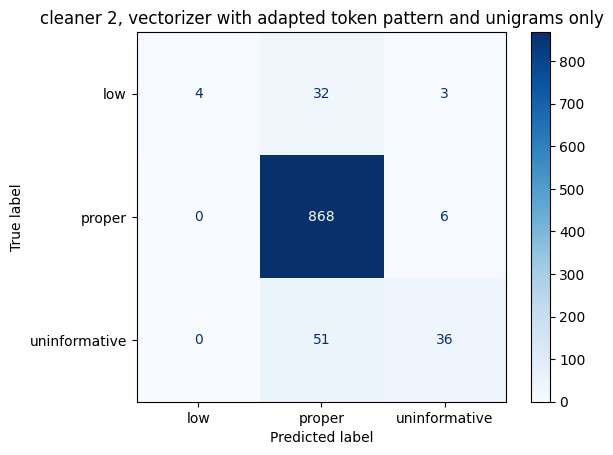

In [ ]:
classification_test(labeled, clean_text2, vectorizer6, "cleaner 2, vectorizer with adapted token pattern and unigrams only")

               precision    recall  f1-score   support

          low       1.00      0.03      0.05        39
       proper       0.91      0.99      0.95       874
uninformative       0.77      0.43      0.55        87

     accuracy                           0.91      1000
    macro avg       0.89      0.48      0.52      1000
 weighted avg       0.90      0.91      0.88      1000



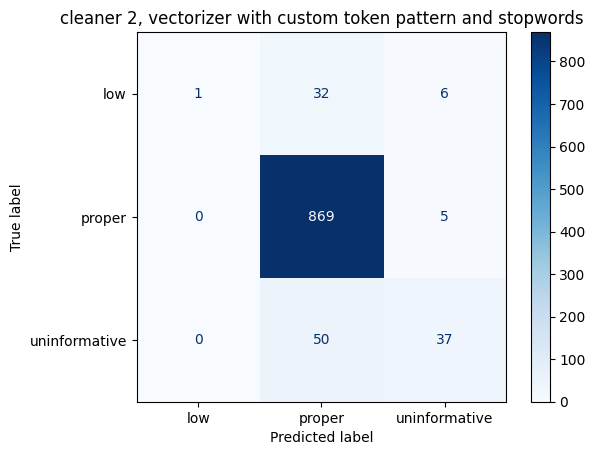

In [ ]:
classification_test(labeled, clean_text2, vectorizer7, "cleaner 2, vectorizer with custom token pattern and stopwords")

               precision    recall  f1-score   support

          low       0.34      0.54      0.42        39
       proper       0.94      0.91      0.92       874
uninformative       0.48      0.49      0.49        87

     accuracy                           0.86      1000
    macro avg       0.59      0.65      0.61      1000
 weighted avg       0.87      0.86      0.86      1000



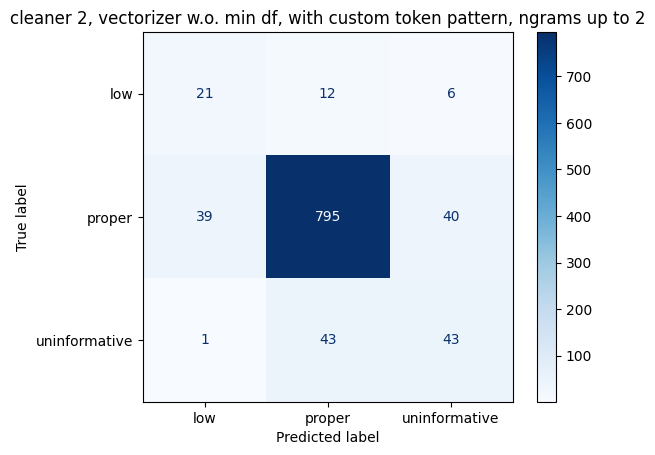

In [ ]:
classification_test(labeled, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. min df, with custom token pattern, ngrams up to 2")

               precision    recall  f1-score   support

          low       0.37      0.54      0.44        39
       proper       0.93      0.94      0.93       874
uninformative       0.60      0.46      0.52        87

     accuracy                           0.88      1000
    macro avg       0.63      0.64      0.63      1000
 weighted avg       0.88      0.88      0.88      1000



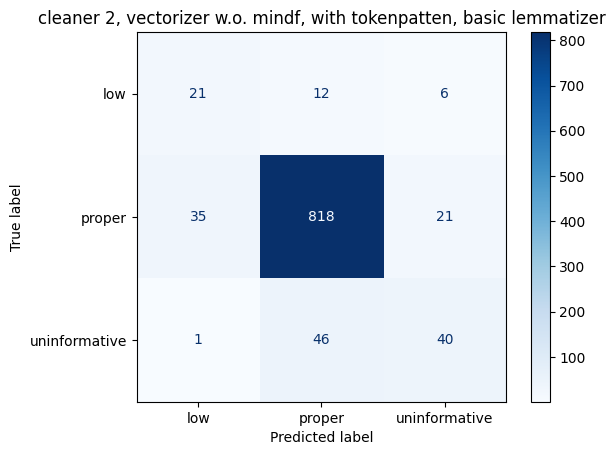

In [ ]:
classification_test(labeled, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. mindf, with tokenpatten, basic lemmatizer",lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.70      0.18      0.29        39
       proper       0.92      0.97      0.95       874
uninformative       0.59      0.47      0.53        87

     accuracy                           0.90      1000
    macro avg       0.74      0.54      0.59      1000
 weighted avg       0.88      0.90      0.88      1000



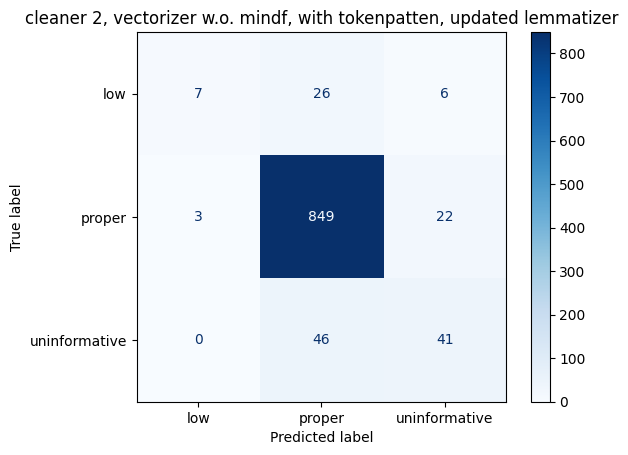

In [ ]:
classification_test(labeled, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. mindf, with tokenpatten, updated lemmatizer",lemmatize_updated)

               precision    recall  f1-score   support

          low       0.33      0.51      0.40        39
       proper       0.93      0.91      0.92       874
uninformative       0.49      0.49      0.49        87

     accuracy                           0.86      1000
    macro avg       0.58      0.64      0.60      1000
 weighted avg       0.87      0.86      0.86      1000



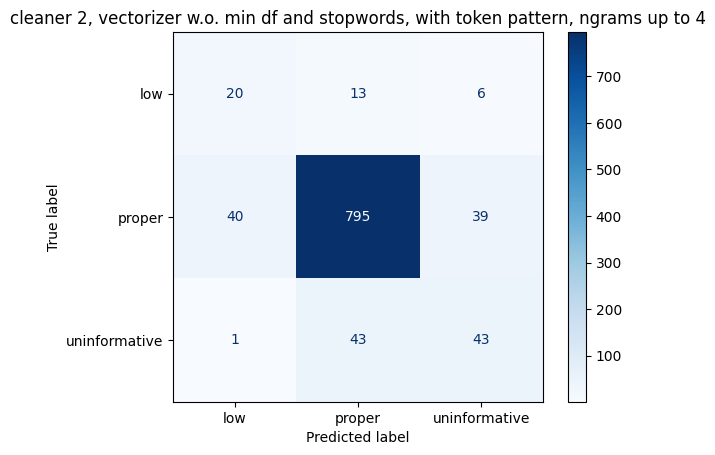

In [ ]:
classification_test(labeled, clean_text2, vectorizer9, "cleaner 2, vectorizer w.o. min df and stopwords, with token pattern, ngrams up to 4")

Optimised Logistic model

               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



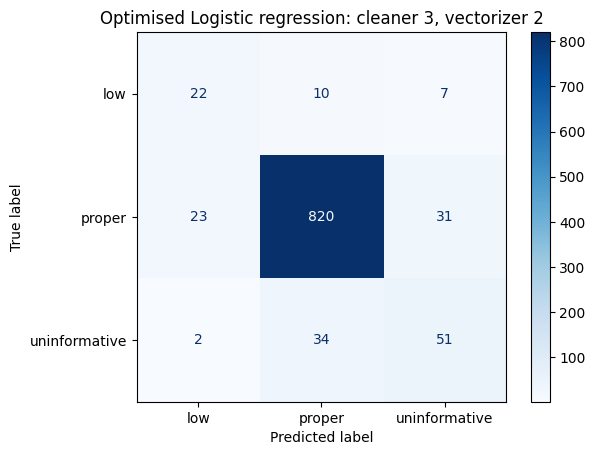

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2, "Optimised Logistic regression: cleaner 3, vectorizer 2")

               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



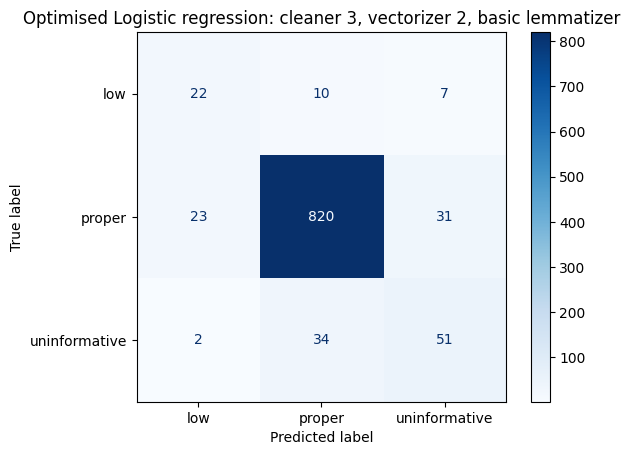

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2, "Optimised Logistic regression: cleaner 3, vectorizer 2, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.48      0.59      0.53        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.71      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



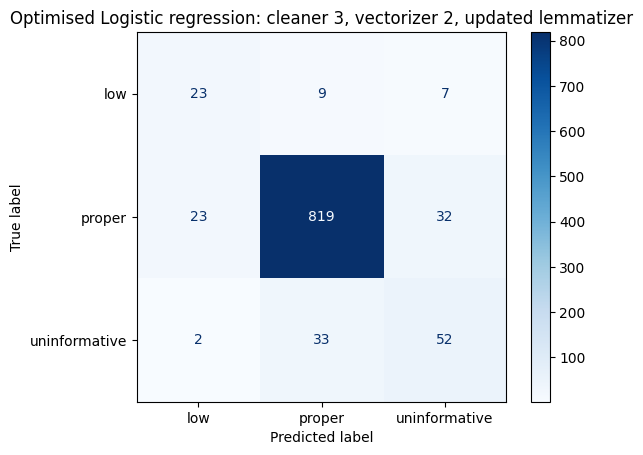

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2, "Optimised Logistic regression: cleaner 3, vectorizer 2, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.47      0.59      0.52        39
       proper       0.95      0.94      0.94       874
uninformative       0.59      0.59      0.59        87

     accuracy                           0.90      1000
    macro avg       0.67      0.71      0.68      1000
 weighted avg       0.90      0.90      0.90      1000



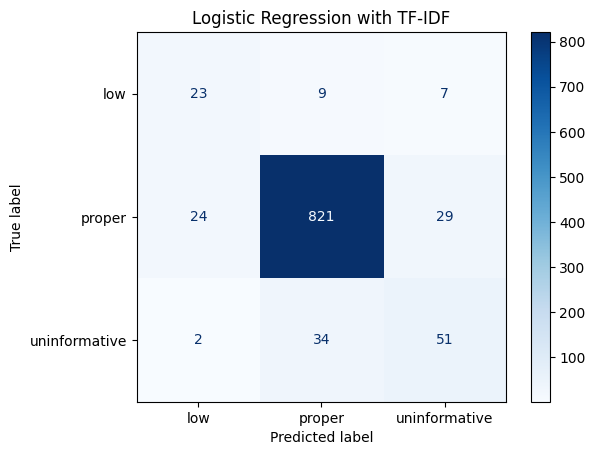

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2_5, "Logistic Regression with TF-IDF")

               precision    recall  f1-score   support

          low       0.48      0.62      0.54        39
       proper       0.95      0.94      0.95       874
uninformative       0.58      0.60      0.59        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.90      0.90      1000



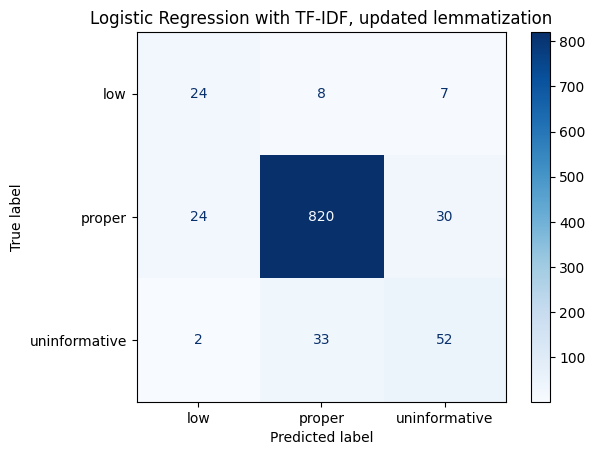

In [ ]:
logistic_opt(labeled, clean_text3, vectorizer2_5, "Logistic Regression with TF-IDF, updated lemmatization", lemmatizer=lemmatize_updated)

               precision    recall  f1-score   support

          low       0.34      0.56      0.43        39
       proper       0.95      0.91      0.93       874
uninformative       0.51      0.59      0.55        87

     accuracy                           0.86      1000
    macro avg       0.60      0.69      0.63      1000
 weighted avg       0.89      0.86      0.87      1000



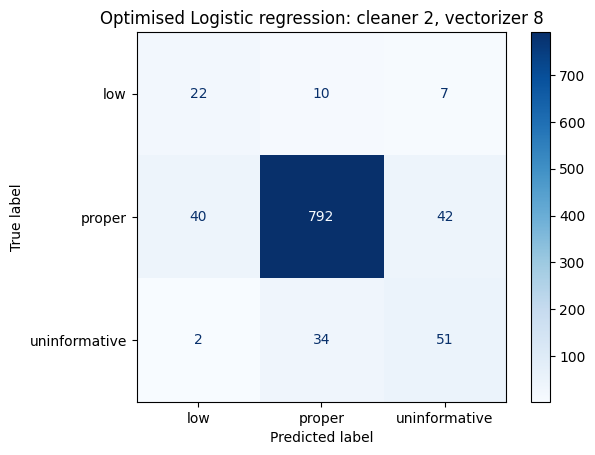

In [ ]:
logistic_opt(labeled, clean_text2, vectorizer8, "Optimised Logistic regression: cleaner 2, vectorizer 8")

               precision    recall  f1-score   support

          low       0.37      0.56      0.44        39
       proper       0.95      0.92      0.93       874
uninformative       0.56      0.57      0.57        87

     accuracy                           0.88      1000
    macro avg       0.63      0.69      0.65      1000
 weighted avg       0.89      0.88      0.88      1000



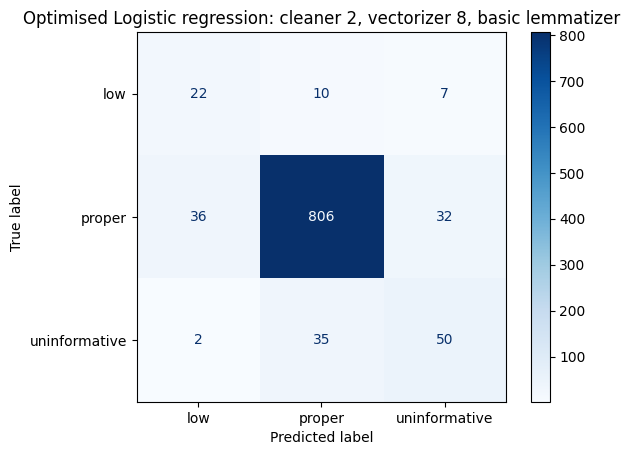

In [ ]:
logistic_opt(labeled, clean_text2, vectorizer8, "Optimised Logistic regression: cleaner 2, vectorizer 8, basic lemmatizer", lemmatize_bio_text)

SVM regression

               precision    recall  f1-score   support

          low       0.69      0.28      0.40        39
       proper       0.94      0.96      0.95       874
uninformative       0.55      0.59      0.57        87

     accuracy                           0.90      1000
    macro avg       0.73      0.61      0.64      1000
 weighted avg       0.89      0.90      0.89      1000



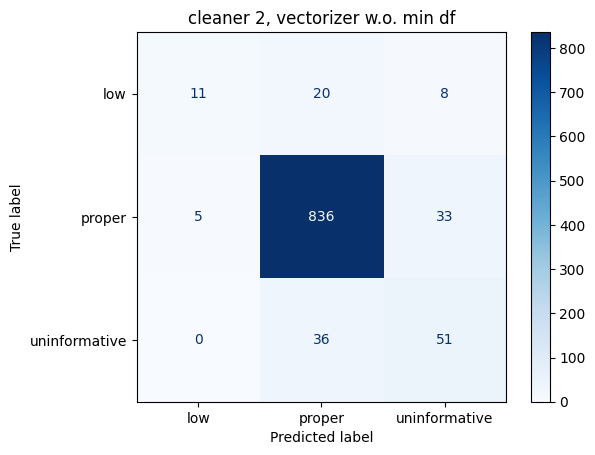

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer2, "cleaner 2, vectorizer w.o. min df")

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



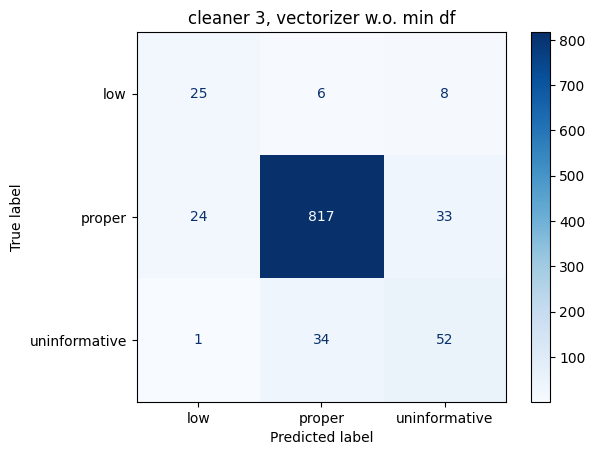

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



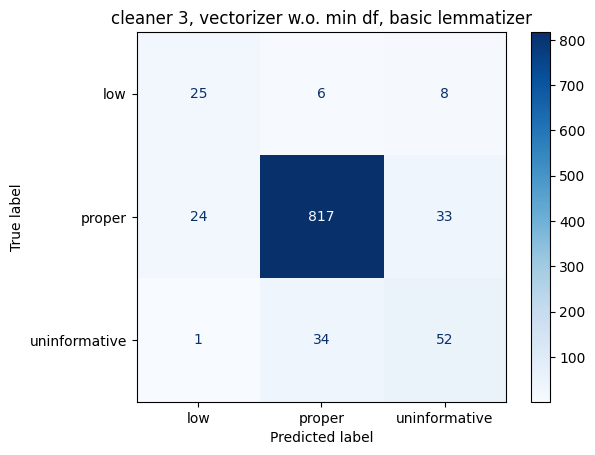

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer",lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.61      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.73      0.70      1000
 weighted avg       0.90      0.89      0.90      1000



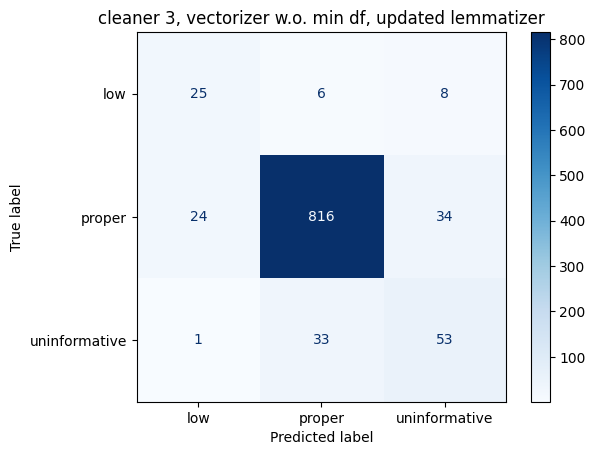

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer",lemmatize_updated)

               precision    recall  f1-score   support

          low       0.39      0.62      0.48        39
       proper       0.95      0.92      0.94       874
uninformative       0.55      0.60      0.57        87

     accuracy                           0.88      1000
    macro avg       0.63      0.71      0.66      1000
 weighted avg       0.90      0.88      0.89      1000



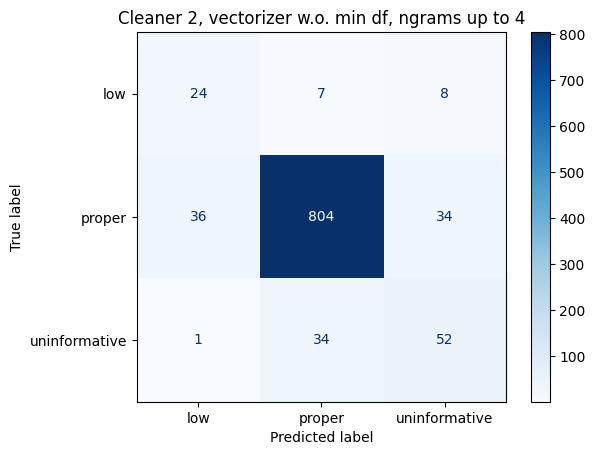

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer2_5, "Cleaner 2, vectorizer w.o. min df, ngrams up to 4")

               precision    recall  f1-score   support

          low       0.39      0.62      0.48        39
       proper       0.95      0.92      0.93       874
uninformative       0.55      0.60      0.57        87

     accuracy                           0.88      1000
    macro avg       0.63      0.71      0.66      1000
 weighted avg       0.89      0.88      0.89      1000



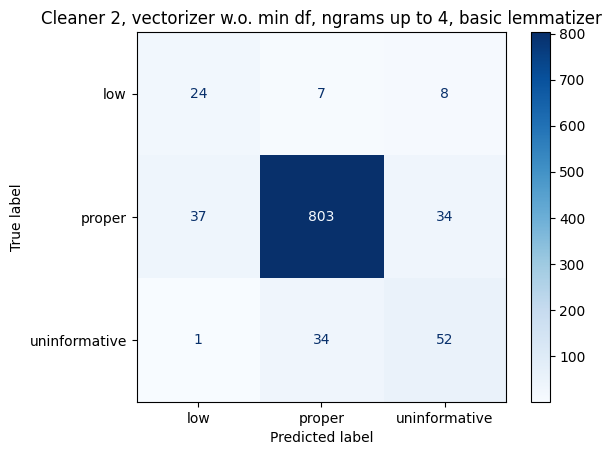

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer2_5, "Cleaner 2, vectorizer w.o. min df, ngrams up to 4, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.64      0.23      0.34        39
       proper       0.94      0.96      0.95       874
uninformative       0.56      0.61      0.59        87

     accuracy                           0.90      1000
    macro avg       0.71      0.60      0.62      1000
 weighted avg       0.89      0.90      0.89      1000



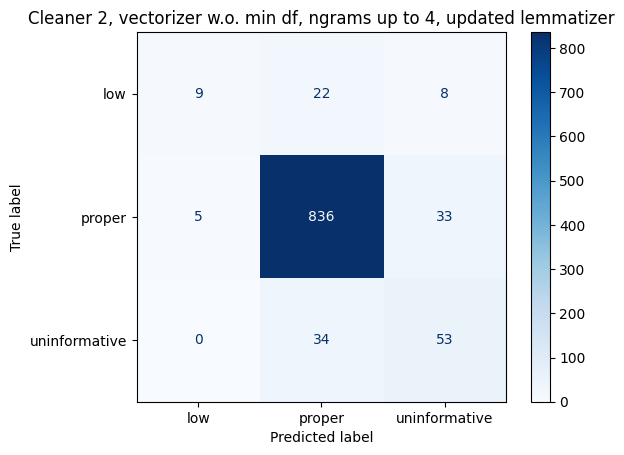

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer2_5, "Cleaner 2, vectorizer w.o. min df, ngrams up to 4, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.49      0.62      0.55        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



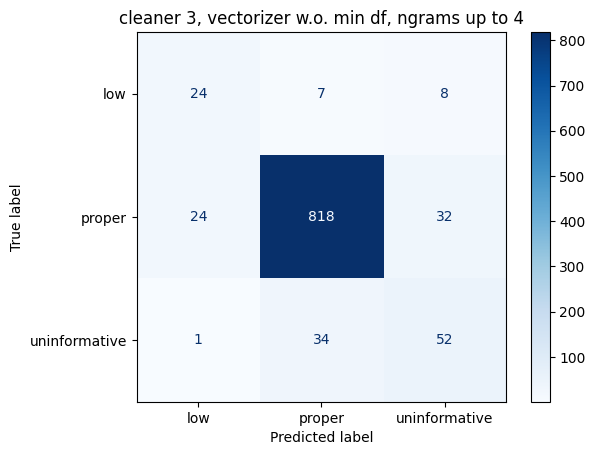

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df, ngrams up to 4")

               precision    recall  f1-score   support

          low       0.48      0.62      0.54        39
       proper       0.95      0.93      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



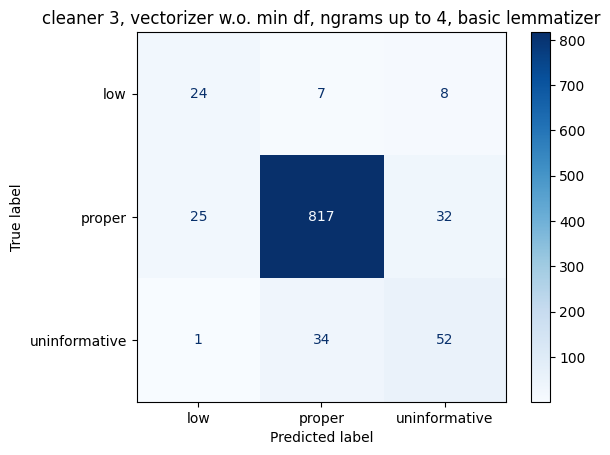

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df, ngrams up to 4, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.48      0.62      0.54        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.61      0.59        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



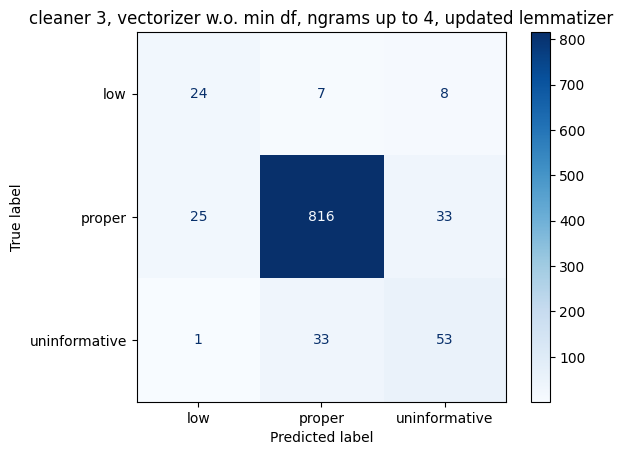

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df, ngrams up to 4, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.38      0.64      0.48        39
       proper       0.95      0.90      0.93       874
uninformative       0.49      0.61      0.54        87

     accuracy                           0.86      1000
    macro avg       0.61      0.72      0.65      1000
 weighted avg       0.89      0.86      0.88      1000



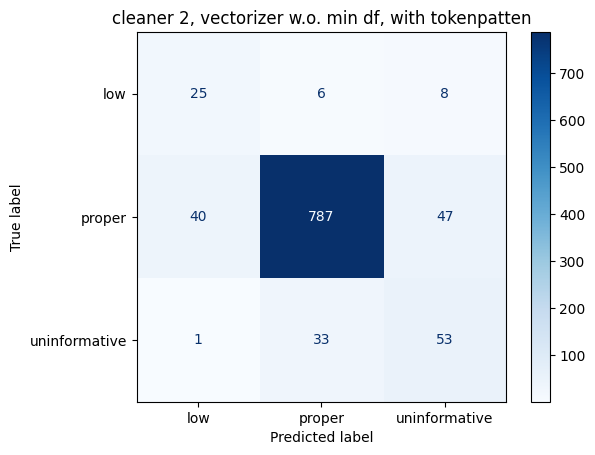

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. min df, with tokenpatten")

               precision    recall  f1-score   support

          low       0.36      0.69      0.47        39
       proper       0.95      0.93      0.94       874
uninformative       0.73      0.54      0.62        87

     accuracy                           0.89      1000
    macro avg       0.68      0.72      0.68      1000
 weighted avg       0.91      0.89      0.89      1000



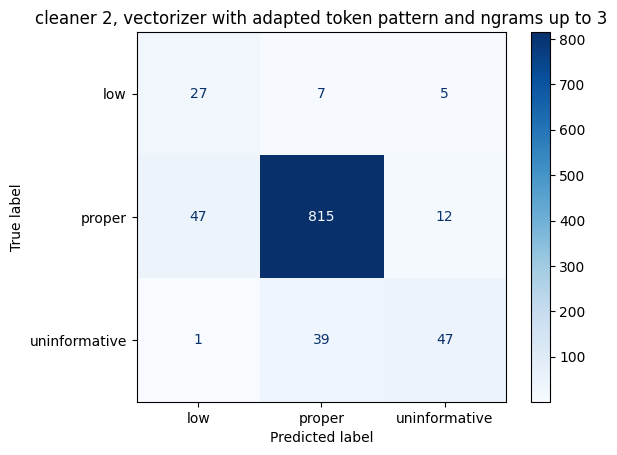

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer5, "cleaner 2, vectorizer with adapted token pattern and ngrams up to 3")

               precision    recall  f1-score   support

          low       0.38      0.64      0.48        39
       proper       0.95      0.90      0.93       874
uninformative       0.49      0.62      0.55        87

     accuracy                           0.86      1000
    macro avg       0.61      0.72      0.65      1000
 weighted avg       0.89      0.86      0.87      1000



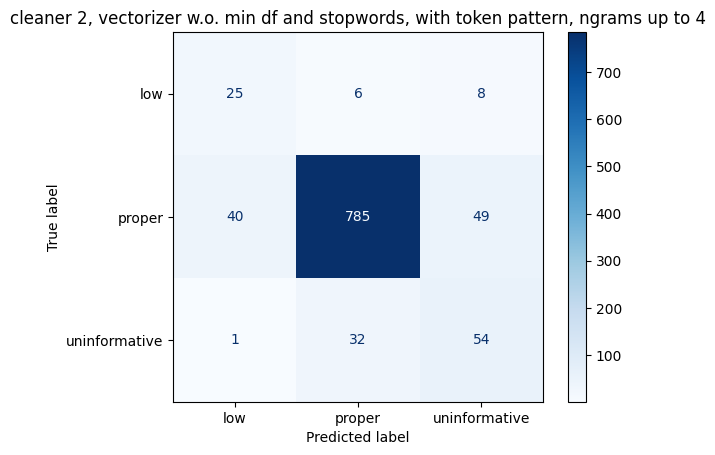

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer9, "cleaner 2, vectorizer w.o. min df and stopwords, with token pattern, ngrams up to 4")

               precision    recall  f1-score   support

          low       0.42      0.69      0.52        39
       proper       0.95      0.92      0.94       874
uninformative       0.56      0.62      0.59        87

     accuracy                           0.88      1000
    macro avg       0.64      0.74      0.68      1000
 weighted avg       0.90      0.88      0.89      1000



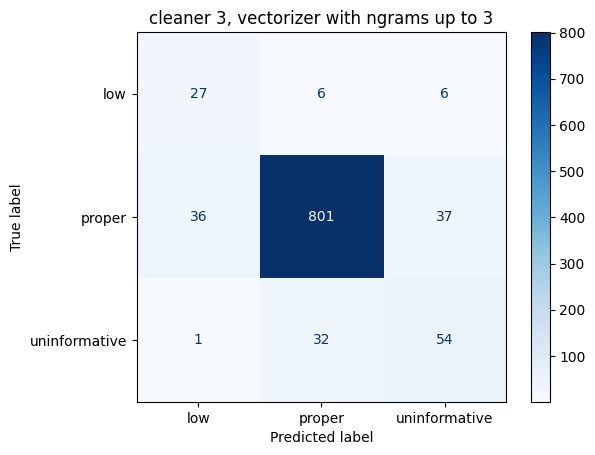

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3")

               precision    recall  f1-score   support

          low       0.44      0.69      0.54        39
       proper       0.95      0.92      0.94       874
uninformative       0.56      0.62      0.59        87

     accuracy                           0.89      1000
    macro avg       0.65      0.74      0.69      1000
 weighted avg       0.90      0.89      0.89      1000



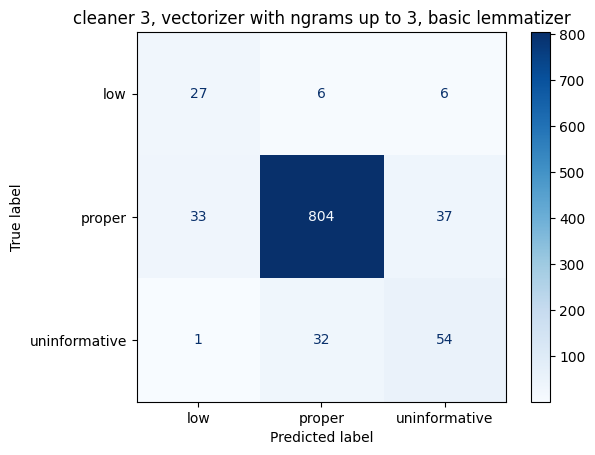

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.44      0.69      0.54        39
       proper       0.95      0.92      0.94       874
uninformative       0.54      0.60      0.57        87

     accuracy                           0.88      1000
    macro avg       0.65      0.74      0.68      1000
 weighted avg       0.90      0.88      0.89      1000



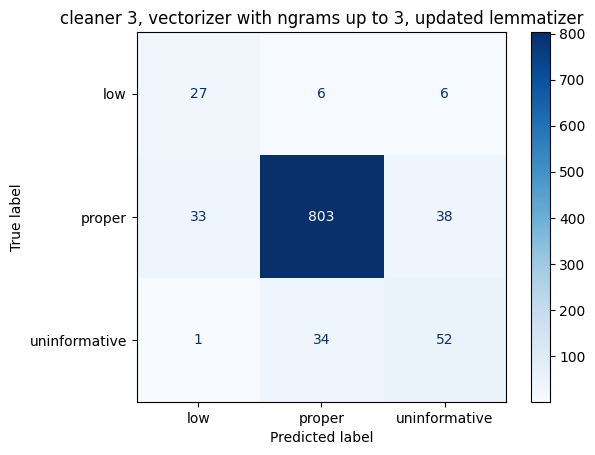

In [ ]:
classificationSVM(labeled, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.35      0.67      0.46        39
       proper       0.95      0.93      0.94       874
uninformative       0.74      0.55      0.63        87

     accuracy                           0.89      1000
    macro avg       0.68      0.72      0.68      1000
 weighted avg       0.91      0.89      0.89      1000



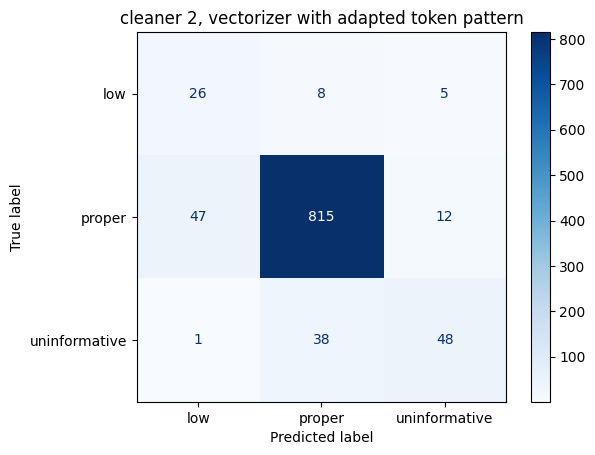

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer4, "cleaner 2, vectorizer with adapted token pattern")

               precision    recall  f1-score   support

          low       0.39      0.69      0.50        39
       proper       0.95      0.91      0.93       874
uninformative       0.55      0.62      0.58        87

     accuracy                           0.87      1000
    macro avg       0.63      0.74      0.67      1000
 weighted avg       0.90      0.87      0.88      1000



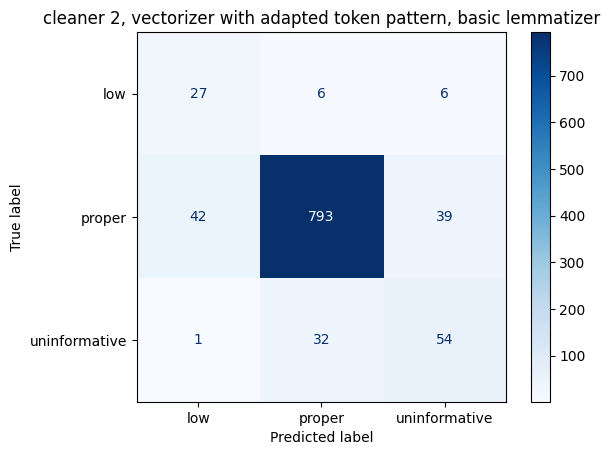

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer4, "cleaner 2, vectorizer with adapted token pattern, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.35      0.67      0.46        39
       proper       0.94      0.92      0.93       874
uninformative       0.66      0.54      0.59        87

     accuracy                           0.88      1000
    macro avg       0.65      0.71      0.66      1000
 weighted avg       0.90      0.88      0.89      1000



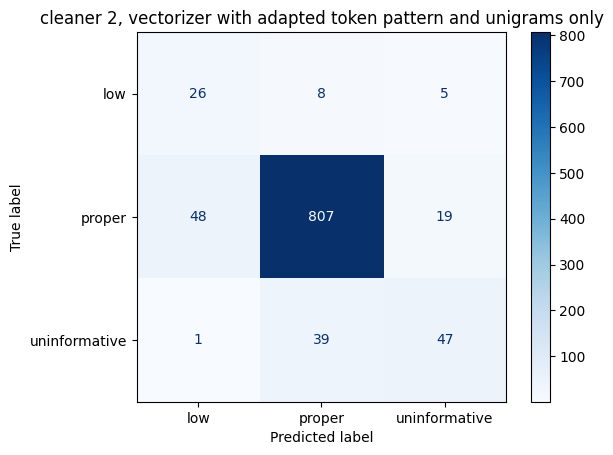

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer6, "cleaner 2, vectorizer with adapted token pattern and unigrams only")

               precision    recall  f1-score   support

          low       0.26      0.41      0.32        39
       proper       0.94      0.93      0.93       874
uninformative       0.64      0.54      0.59        87

     accuracy                           0.88      1000
    macro avg       0.61      0.63      0.61      1000
 weighted avg       0.89      0.88      0.88      1000



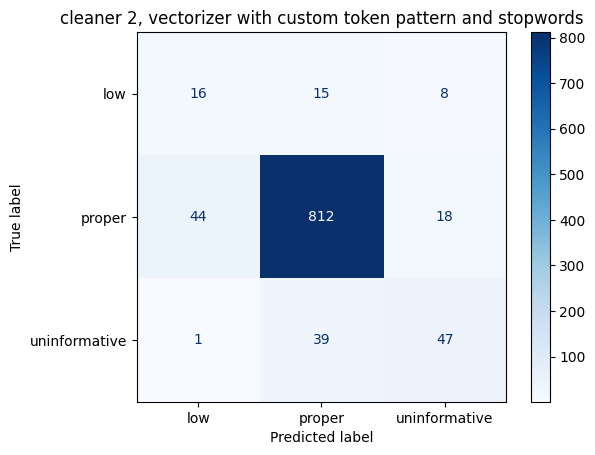

In [ ]:
classificationSVM(labeled, clean_text2, vectorizer7, "cleaner 2, vectorizer with custom token pattern and stopwords")

Optimised SVM

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



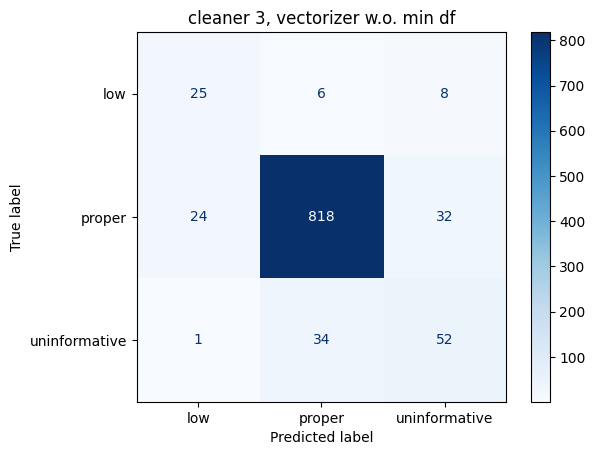

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



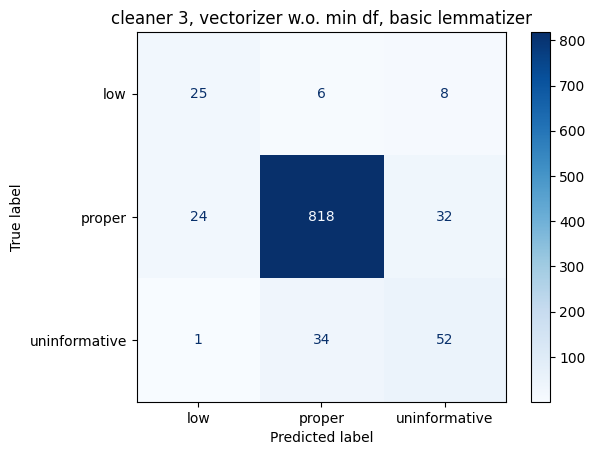

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer",lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.61      0.59        87

     accuracy                           0.90      1000
    macro avg       0.67      0.73      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



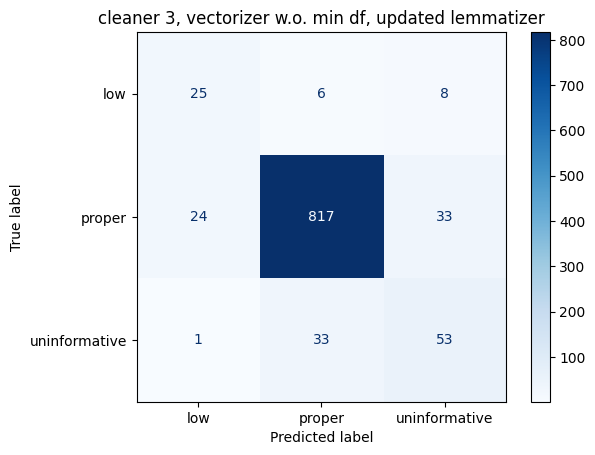

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer",lemmatize_updated)

               precision    recall  f1-score   support

          low       0.49      0.62      0.55        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.90      0.90      1000



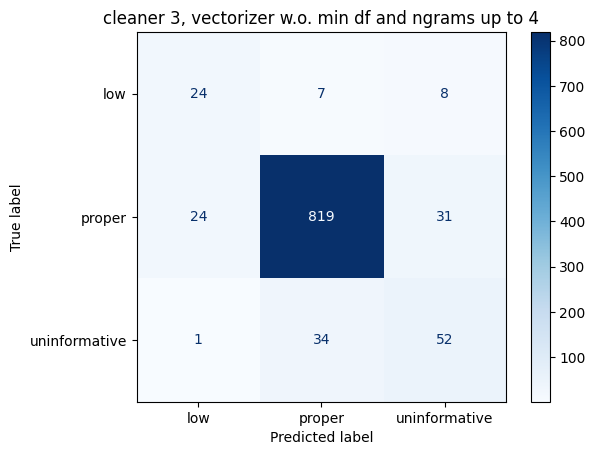

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams up to 4")

               precision    recall  f1-score   support

          low       0.48      0.62      0.54        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



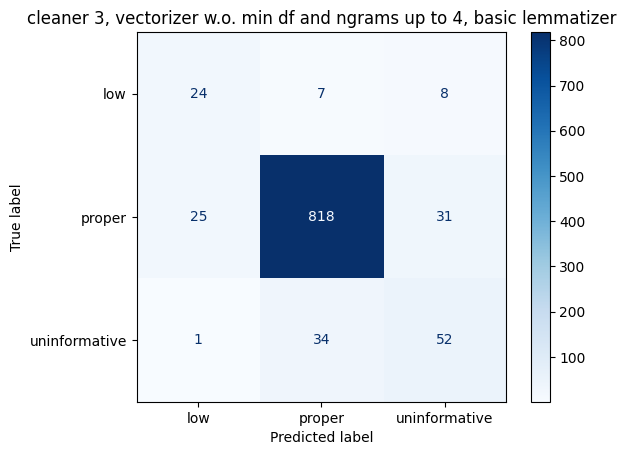

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams up to 4, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.48      0.62      0.54        39
       proper       0.95      0.93      0.94       874
uninformative       0.57      0.61      0.59        87

     accuracy                           0.89      1000
    macro avg       0.67      0.72      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



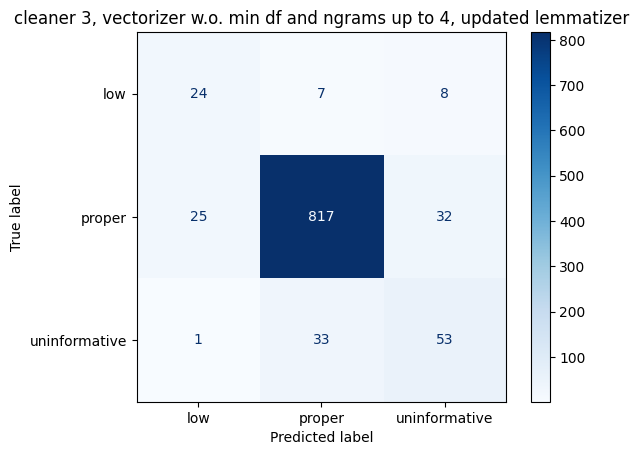

In [ ]:
SVMopt(labeled, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams up to 4, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.35      0.67      0.46        39
       proper       0.95      0.93      0.94       874
uninformative       0.73      0.54      0.62        87

     accuracy                           0.89      1000
    macro avg       0.68      0.71      0.67      1000
 weighted avg       0.90      0.89      0.89      1000



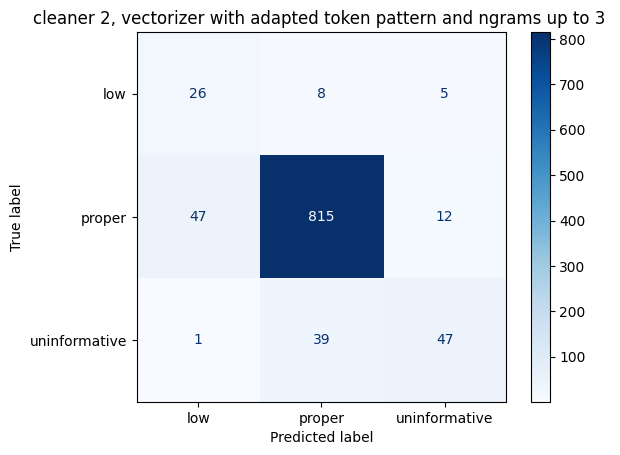

In [ ]:
SVMopt(labeled, clean_text2, vectorizer5, "cleaner 2, vectorizer with adapted token pattern and ngrams up to 3 ")

               precision    recall  f1-score   support

          low       0.42      0.69      0.52        39
       proper       0.95      0.92      0.94       874
uninformative       0.56      0.62      0.59        87

     accuracy                           0.88      1000
    macro avg       0.64      0.74      0.68      1000
 weighted avg       0.90      0.88      0.89      1000



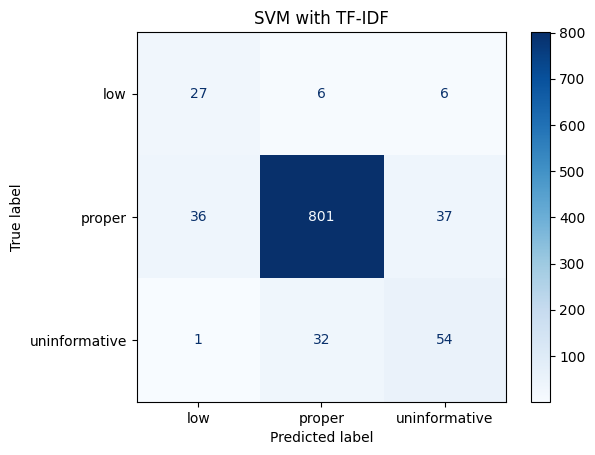

In [ ]:
SVMopt(labeled, clean_text3, vectorizer3, "SVM with TF-IDF")

               precision    recall  f1-score   support

          low       0.44      0.69      0.54        39
       proper       0.95      0.92      0.94       874
uninformative       0.55      0.62      0.58        87

     accuracy                           0.88      1000
    macro avg       0.65      0.74      0.69      1000
 weighted avg       0.90      0.88      0.89      1000



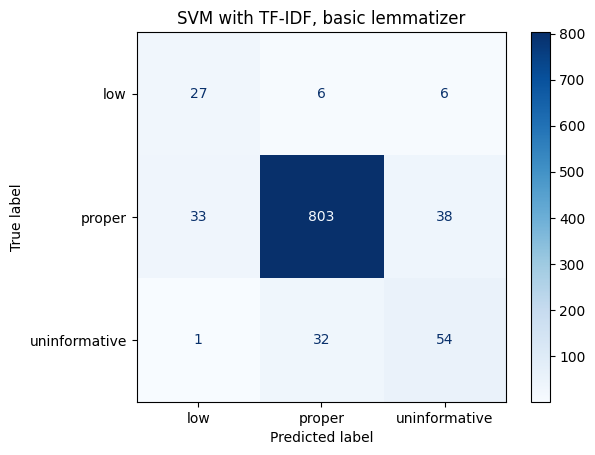

In [ ]:
SVMopt(labeled, clean_text3, vectorizer3, "SVM with TF-IDF, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.45      0.69      0.55        39
       proper       0.95      0.92      0.94       874
uninformative       0.54      0.60      0.57        87

     accuracy                           0.88      1000
    macro avg       0.65      0.74      0.68      1000
 weighted avg       0.90      0.88      0.89      1000



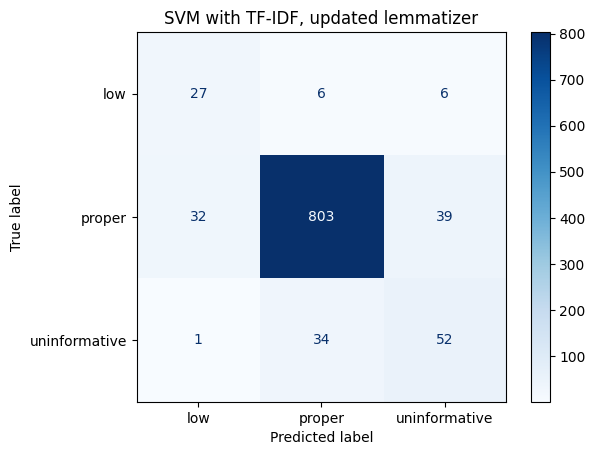

In [ ]:
SVMopt(labeled, clean_text3, vectorizer3, "SVM with TF-IDF, updated lemmatizer", lemmatize_updated)

               precision    recall  f1-score   support

          low       0.35      0.67      0.46        39
       proper       0.95      0.93      0.94       874
uninformative       0.73      0.54      0.62        87

     accuracy                           0.89      1000
    macro avg       0.68      0.71      0.67      1000
 weighted avg       0.90      0.89      0.89      1000



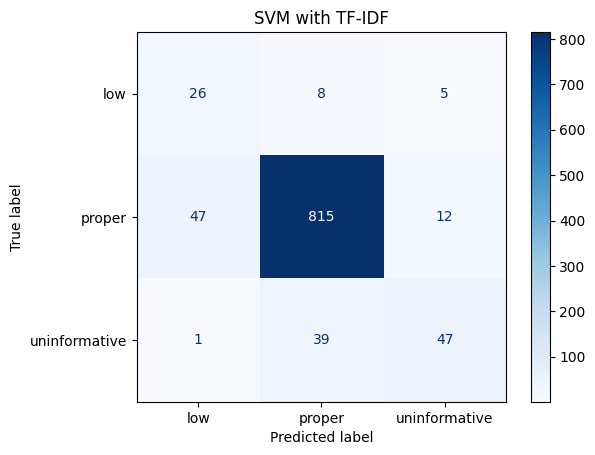

In [21]:
SVMopt(labeled, clean_text2, vectorizer4, "SVM with TF-IDF")

Random forest

               precision    recall  f1-score   support

          low       0.24      0.67      0.36        39
       proper       0.95      0.84      0.89       874
uninformative       0.42      0.60      0.49        87

     accuracy                           0.81      1000
    macro avg       0.54      0.70      0.58      1000
 weighted avg       0.88      0.81      0.84      1000



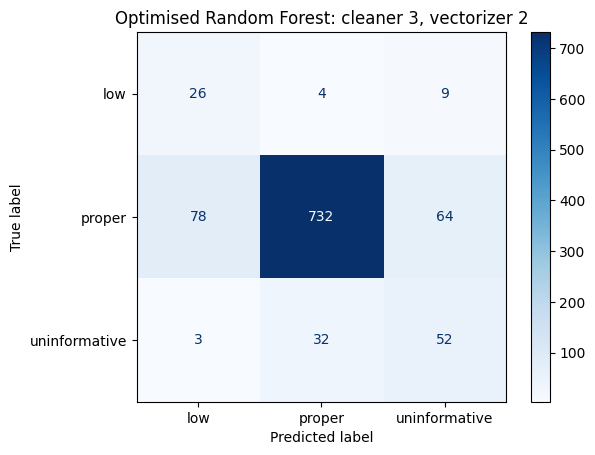

In [ ]:
RF(labeled, clean_text3, vectorizer2, "Optimised Random Forest: cleaner 3, vectorizer 2")

               precision    recall  f1-score   support

          low       0.24      0.67      0.35        39
       proper       0.95      0.84      0.89       874
uninformative       0.43      0.56      0.49        87

     accuracy                           0.81      1000
    macro avg       0.54      0.69      0.58      1000
 weighted avg       0.88      0.81      0.84      1000



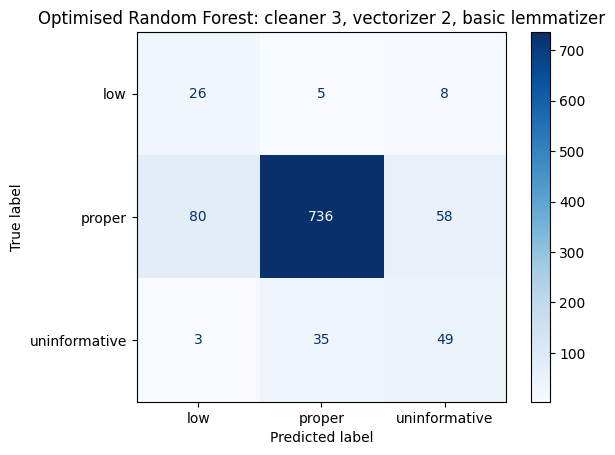

In [ ]:
RF(labeled, clean_text3, vectorizer2, "Optimised Random Forest: cleaner 3, vectorizer 2, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.24      0.67      0.36        39
       proper       0.95      0.87      0.91       874
uninformative       0.53      0.53      0.53        87

     accuracy                           0.84      1000
    macro avg       0.57      0.69      0.60      1000
 weighted avg       0.88      0.84      0.85      1000



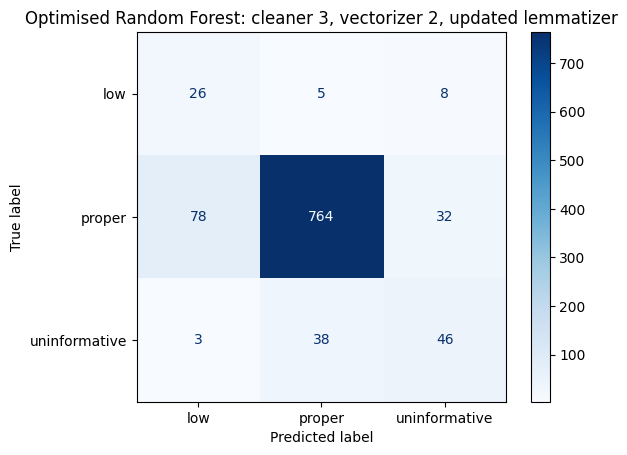

In [ ]:
RF(labeled, clean_text3, vectorizer2, "Optimised Random Forest: cleaner 3, vectorizer 2, updated lemmatizer", lemmatize_updated)

Multimodal Naive Bayes

               precision    recall  f1-score   support

          low       0.45      0.51      0.48        39
       proper       0.94      0.96      0.95       874
uninformative       0.71      0.52      0.60        87

     accuracy                           0.90      1000
    macro avg       0.70      0.66      0.68      1000
 weighted avg       0.90      0.90      0.90      1000



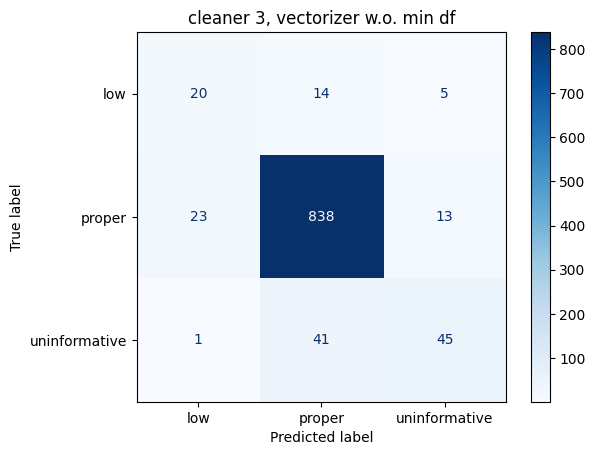

In [ ]:
MNB(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

               precision    recall  f1-score   support

          low       0.44      0.51      0.48        39
       proper       0.94      0.96      0.95       874
uninformative       0.71      0.52      0.60        87

     accuracy                           0.90      1000
    macro avg       0.70      0.66      0.67      1000
 weighted avg       0.90      0.90      0.90      1000



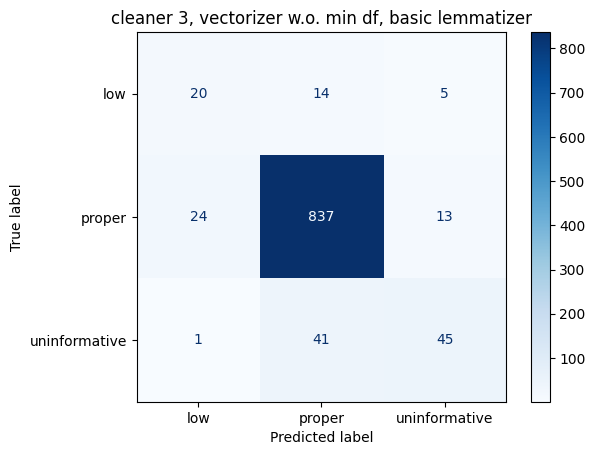

In [ ]:
MNB(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.44      0.51      0.48        39
       proper       0.94      0.96      0.95       874
uninformative       0.71      0.52      0.60        87

     accuracy                           0.90      1000
    macro avg       0.70      0.66      0.67      1000
 weighted avg       0.90      0.90      0.90      1000



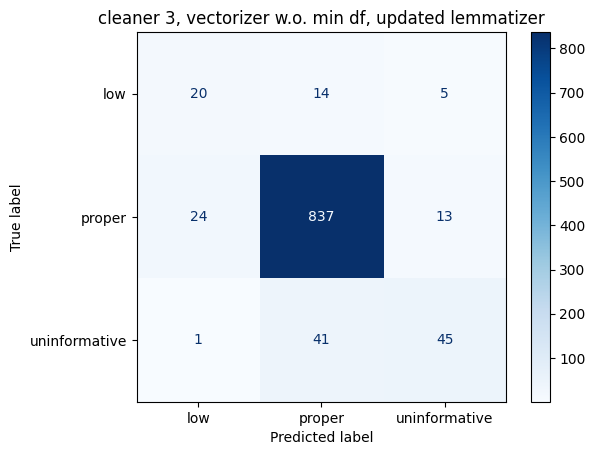

In [ ]:
MNB(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer", lemmatize_updated)

Complement Naive Bayes

               precision    recall  f1-score   support

          low       0.29      0.79      0.42        39
       proper       0.98      0.89      0.93       874
uninformative       0.54      0.61      0.57        87

     accuracy                           0.86      1000
    macro avg       0.60      0.76      0.64      1000
 weighted avg       0.92      0.86      0.88      1000



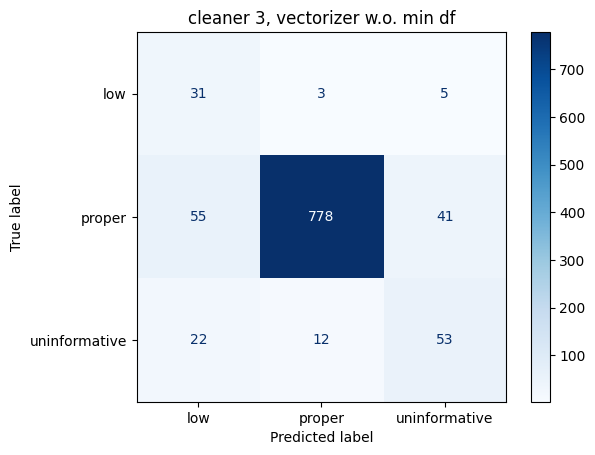

In [ ]:
CNB(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

               precision    recall  f1-score   support

          low       0.29      0.79      0.42        39
       proper       0.98      0.89      0.93       874
uninformative       0.54      0.61      0.57        87

     accuracy                           0.86      1000
    macro avg       0.60      0.77      0.64      1000
 weighted avg       0.92      0.86      0.88      1000



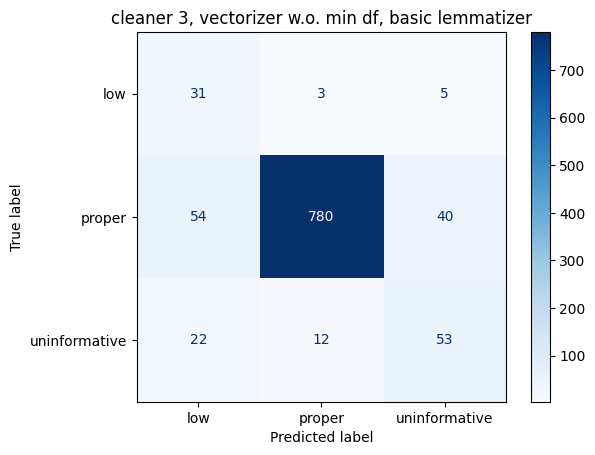

In [ ]:
CNB(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.29      0.79      0.42        39
       proper       0.98      0.89      0.93       874
uninformative       0.54      0.62      0.58        87

     accuracy                           0.86      1000
    macro avg       0.60      0.77      0.65      1000
 weighted avg       0.92      0.86      0.88      1000



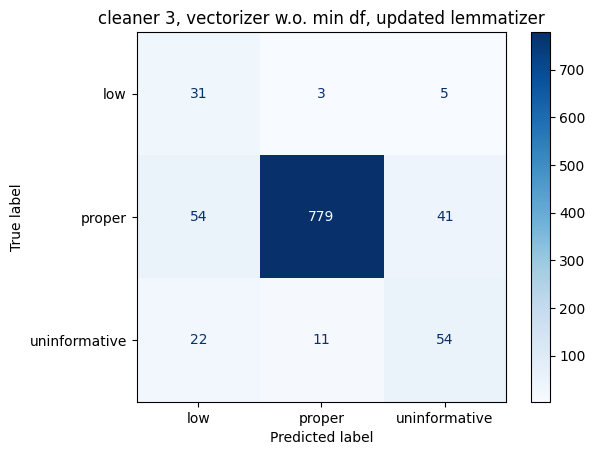

In [ ]:
CNB(labeled, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer", lemmatize_updated)